In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr, f_oneway
from scipy.spatial.distance import pdist, squareform
import itertools
from itertools import combinations

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']  # This is the default LaTeX font
plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16, 'axes.titlesize': 16, 'legend.fontsize': 14})
# Reading the data
df = pd.read_csv('current_analysis/xdbc_experiments_master.csv')
df.drop(columns=['client_readmode', 'table', 'host', 'date', 'run'], inplace=True)
df = df[df['time']>3]

In [8]:
# Assuming df is your dataframe
this_df = df.copy()
this_df['env_id'] = this_df['server_cpu'].astype(str) + '-' + this_df['client_cpu'].astype(str) + '-' + this_df['network'].astype(str)

parameter_cols = ['compression', 'format', 'network_parallelism', 'bufpool_size', 'buff_size', 
                  'client_read_par', 'client_decomp_par', 'server_read_par', 'server_read_partitions', 'server_deser_par']

grouped = this_df.groupby(parameter_cols)['env_id'].nunique().reset_index()

configs_run_in_27_envs = grouped[grouped['env_id'] == 27]

display(configs_run_in_27_envs.count())
display(configs_run_in_27_envs)


compression               1115
format                    1115
network_parallelism       1115
bufpool_size              1115
buff_size                 1115
client_read_par           1115
client_decomp_par         1115
server_read_par           1115
server_read_partitions    1115
server_deser_par          1115
env_id                    1115
dtype: int64

compression  format  network_parallelism  bufpool_size  buff_size  \
6            cols       1                    1          1000       1000   
16           cols       1                    1          1000       1000   
26           cols       1                    1          1000       1000   
41           cols       1                    1          1000       1000   
59           cols       1                    1          1000       1000   
66           cols       1                    1          1000       1000   
95           cols       1                    1          1000       1000   
97           cols       1                    1          1000       1000   
101          cols       1                    1          1000       1000   
110          cols       1                    1          1000       1000   
151          cols       1                    1          1000       1000   
163          cols       1                    1          1000       1000   
164          cols       1                    1          1000       1000   
172          cols       1                    1          1000       1000   
191          cols       1                    1          1000       1000   
205          cols       1                    1          1000       1000   
207          cols       1                    1          1000       1000   
211          cols       1                    1          1000       1000   
230          cols       1                    1          1000       1000   
239          cols       1                    1          1000       1000   
255          cols       1                    1          1000       1000   
259          cols       1                    1          1000       1000   
306          cols       1                    1          1000       1000   
307          cols       1                    1          1000       1000   
317          cols       1                    1          1000       1000   
318          cols       1                    1          1000       1000   
321          cols       1                    1          1000       1000   
325          cols       1                    1          1000       1000   
337          cols       1                    1          1000       1000   
347          cols       1                    1          1000       1000   
363          cols       1                    1          1000       1000   
402          cols       1                    1          1000       1000   
404          cols       1                    1          1000       1000   
761          cols       1                    1          1000      10000   
785          cols       1                    1          1000      10000   
808          cols       1                    1          1000      10000   
910          cols       1                    2          1000       1000   
914          cols       1                    2          1000       1000   
926          cols       1                    2          1000       1000   
932          cols       1                    2          1000       1000   
950          cols       1                    2          1000       1000   
977          cols       1                    2          1000       1000   
991          cols       1                    2          1000       1000   
1055         cols       1                    2          1000       1000   
1113         cols       1                    2          1000       1000   
1116         cols       1                    2          1000       1000   
1146         cols       1                    2          1000       1000   
1155         cols       1                    2          1000       1000   
1202         cols       1                    2          1000       1000   
1206         cols       1                    2          1000       1000   
1218         cols       1                    2          1000       1000   
1225         cols       1                    2          1000       1000   
1239         cols       1      

In [112]:
# Create a copy of the dataframe
df_copy = df.copy()
df_copy = df_copy[(df_copy['compression'] != 'zlib') & (df_copy['compression'] != 'cols')]

# Convert parameter configurations and environments to string representations
df_copy['param_config'] = df_copy[parameter_cols].astype(str).agg('-'.join, axis=1)
df_copy['environment'] = df_copy[env_cols].astype(str).agg('-'.join, axis=1)

# Filter configurations with entries for all 27 environments
complete_configs = df_copy.groupby('param_config').filter(lambda x: x['environment'].nunique() == 27)['param_config'].unique()

# Restrict to these configurations
filtered_df = df_copy[df_copy['param_config'].isin(complete_configs)]

# Pivot table for easier calculations
pivot_df = filtered_df.pivot_table(index='param_config', columns='environment', values='time', aggfunc='mean')

# Compute the differences
differences = pivot_df.values[:, None, :] - pivot_df.values[None, :, :]

# Determine where one configuration is faster than the other
trading_places = differences > 0

# Count how many times each configuration pair trades places
ranking = trading_places.sum(axis=2)

# Compute the total absolute differences for each pair
total_abs_diff = np.abs(differences).sum(axis=2)

# Normalize the trading places count and total absolute difference
norm_ranking = ranking / ranking.max()
norm_total_abs_diff = total_abs_diff / total_abs_diff.max()

# Combine the two normalized scores
combined_score = norm_ranking + norm_total_abs_diff

# Mask diagonal and lower triangle to avoid duplicates and self-comparison
mask = np.triu(np.ones_like(combined_score), k=1)
combined_score_masked = np.where(mask, combined_score, 0)

# Extract the indices of the top pair
i, j = np.unravel_index(combined_score_masked.argmax(axis=None), combined_score.shape)


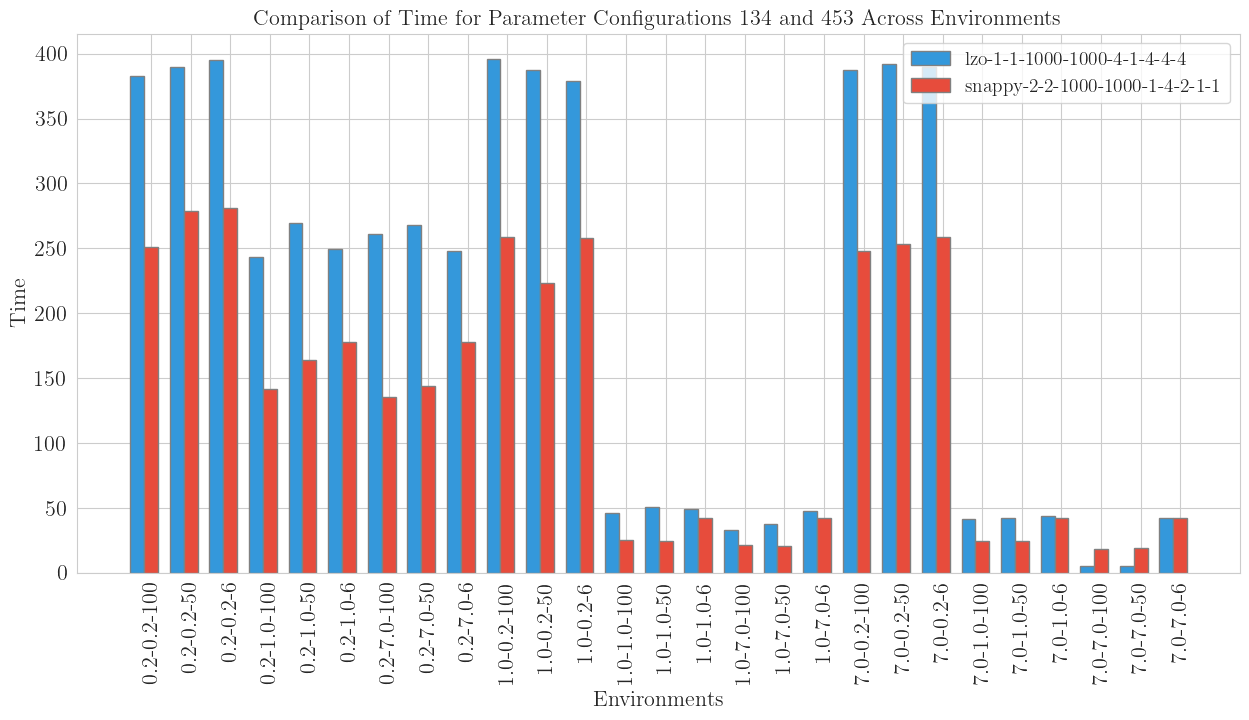

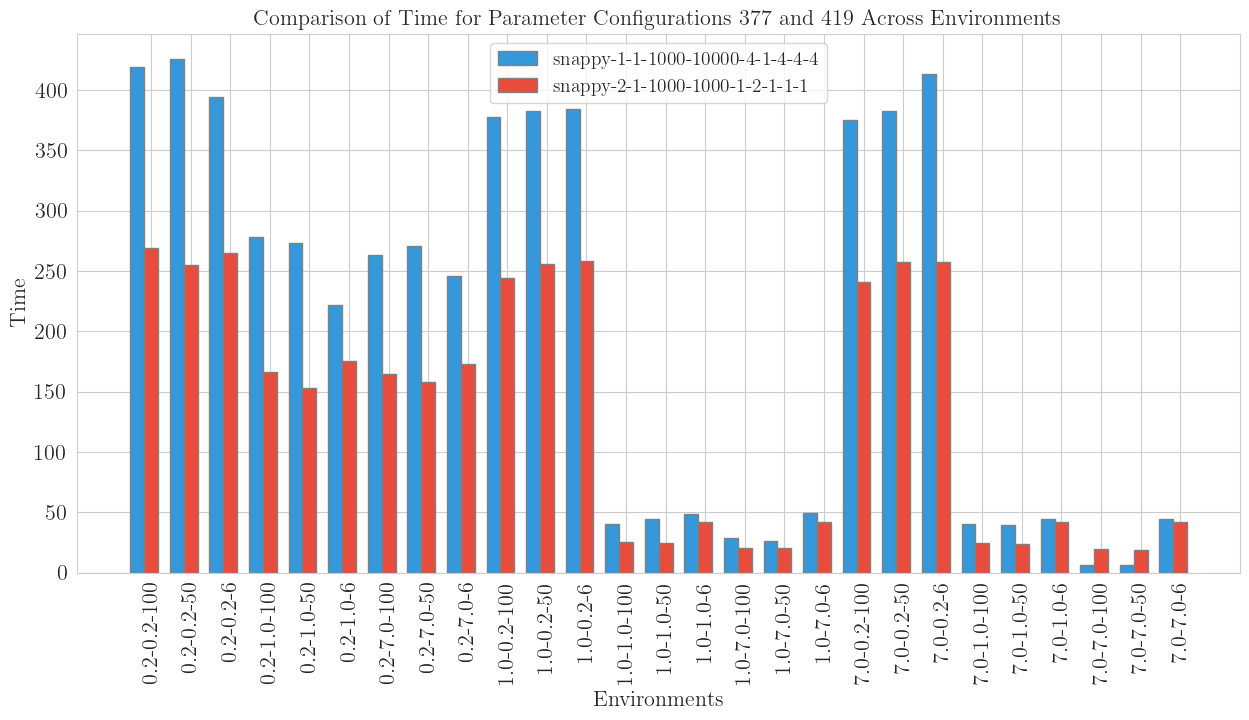

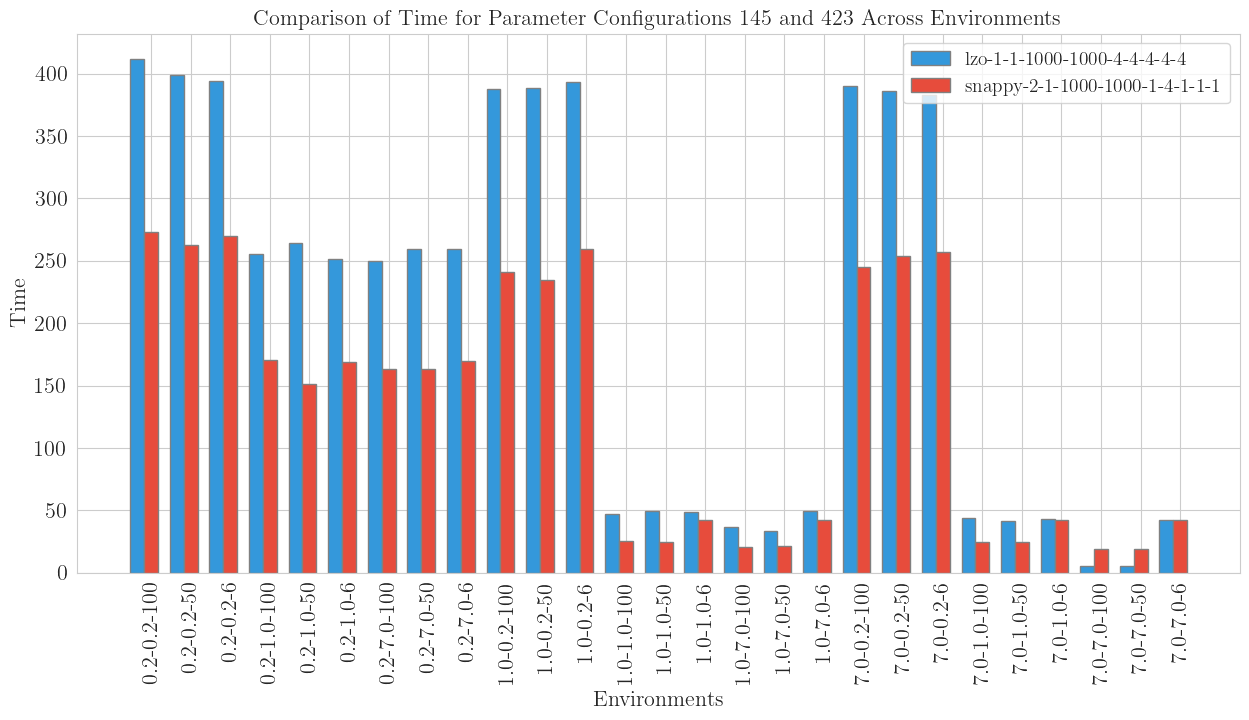

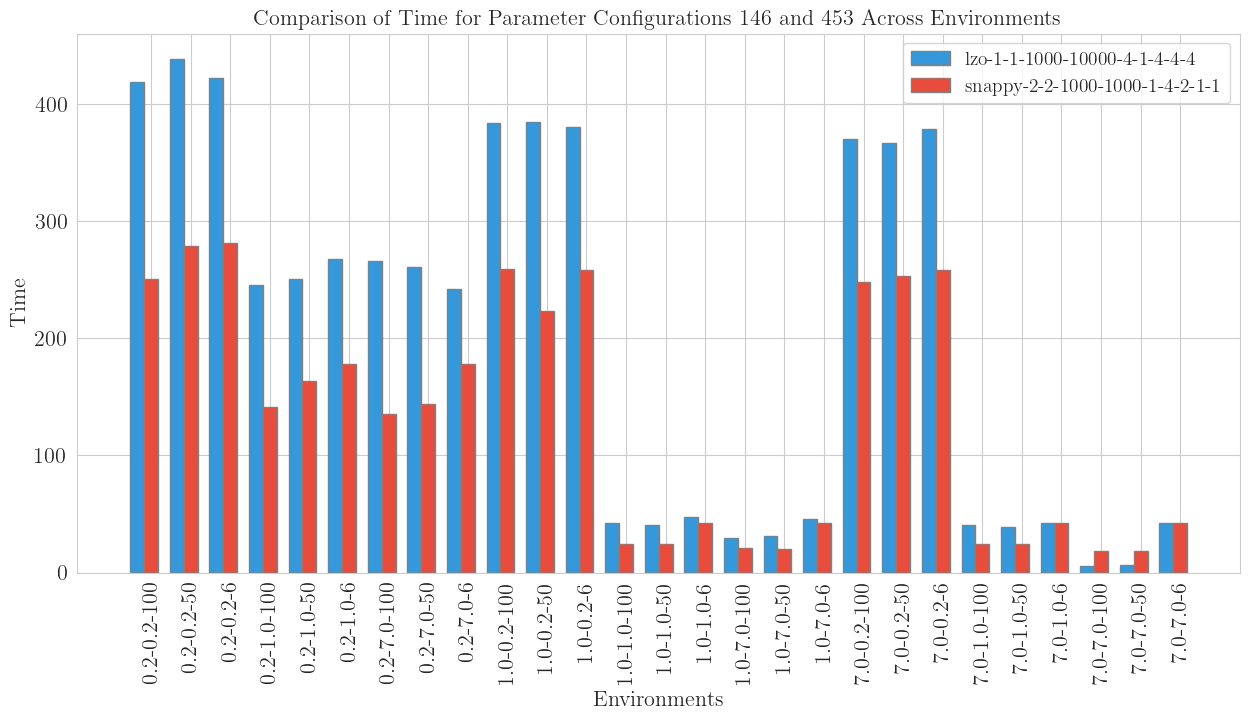

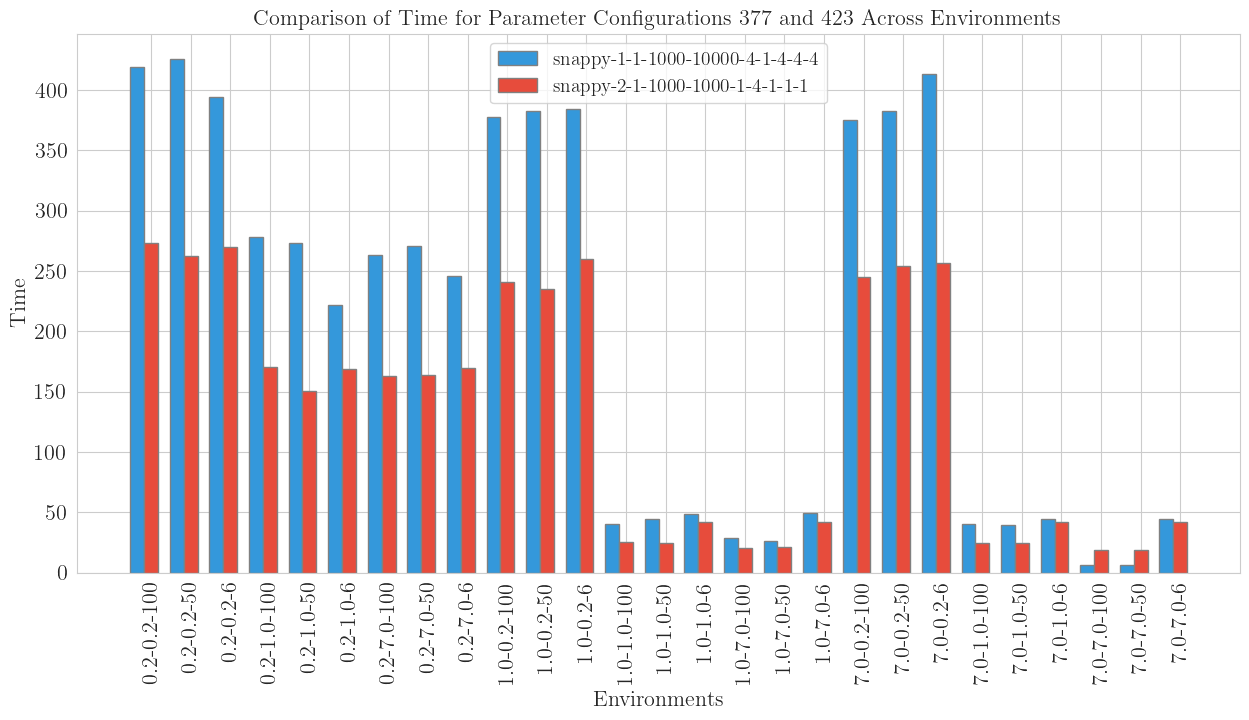

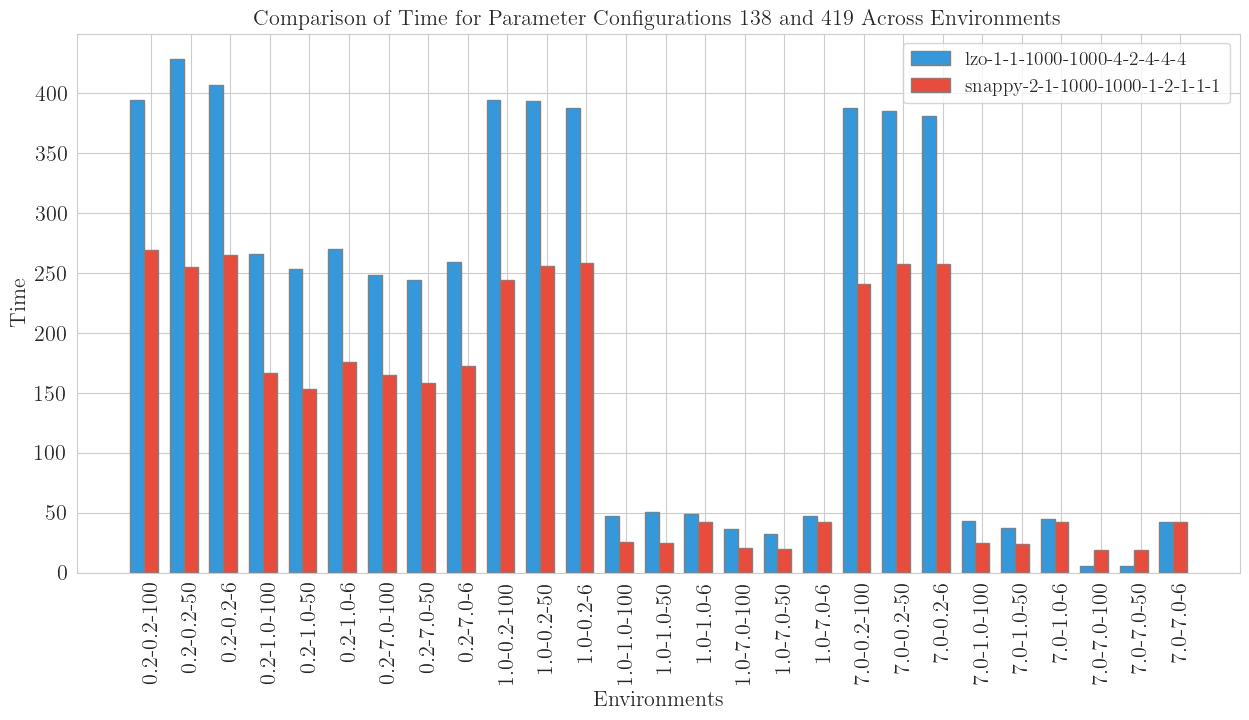

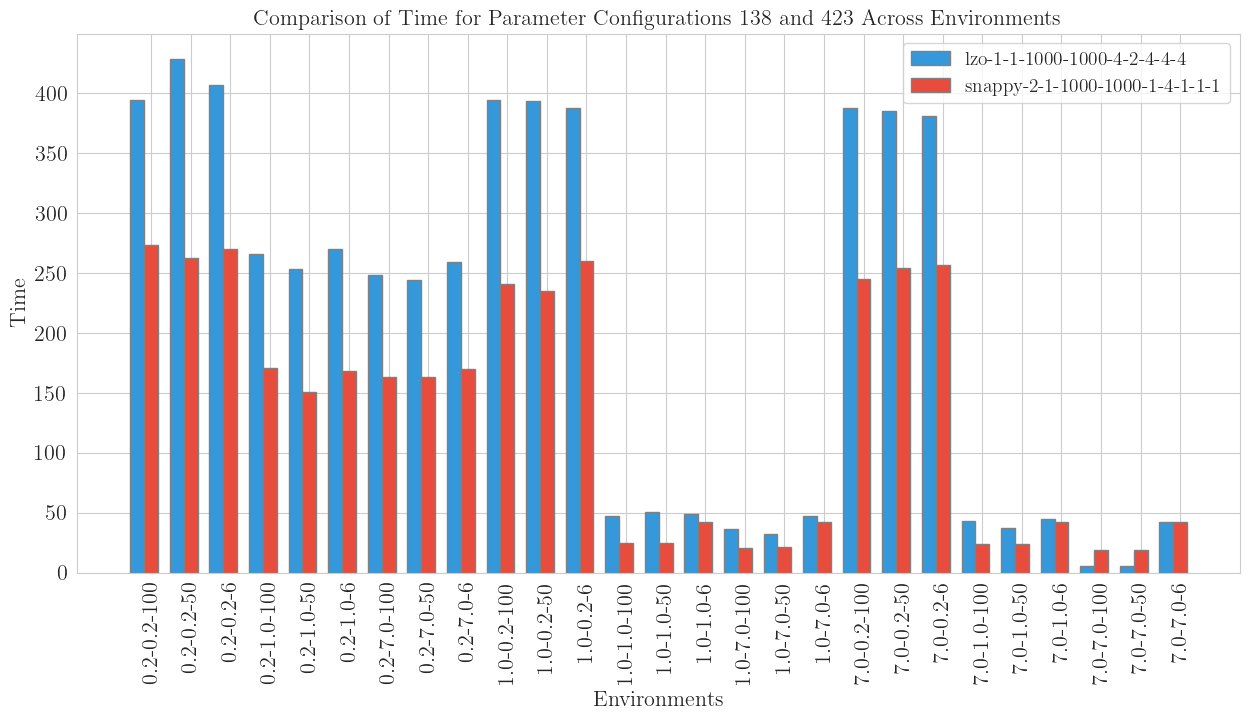

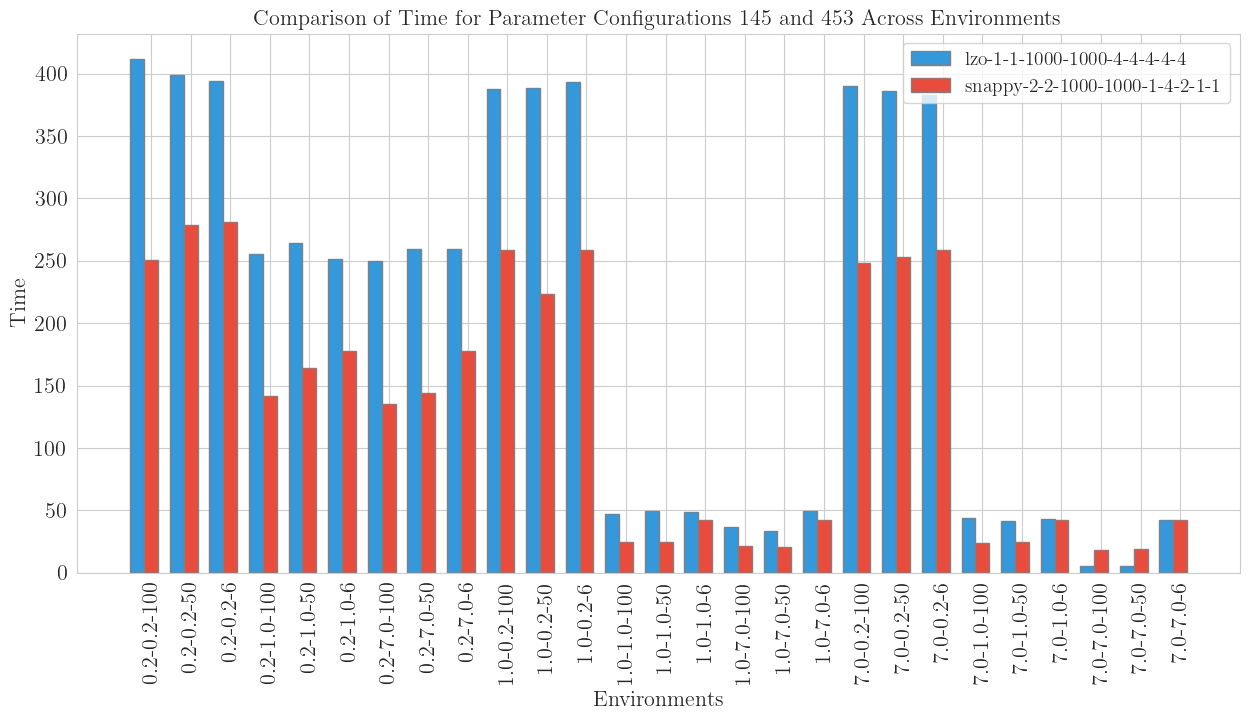

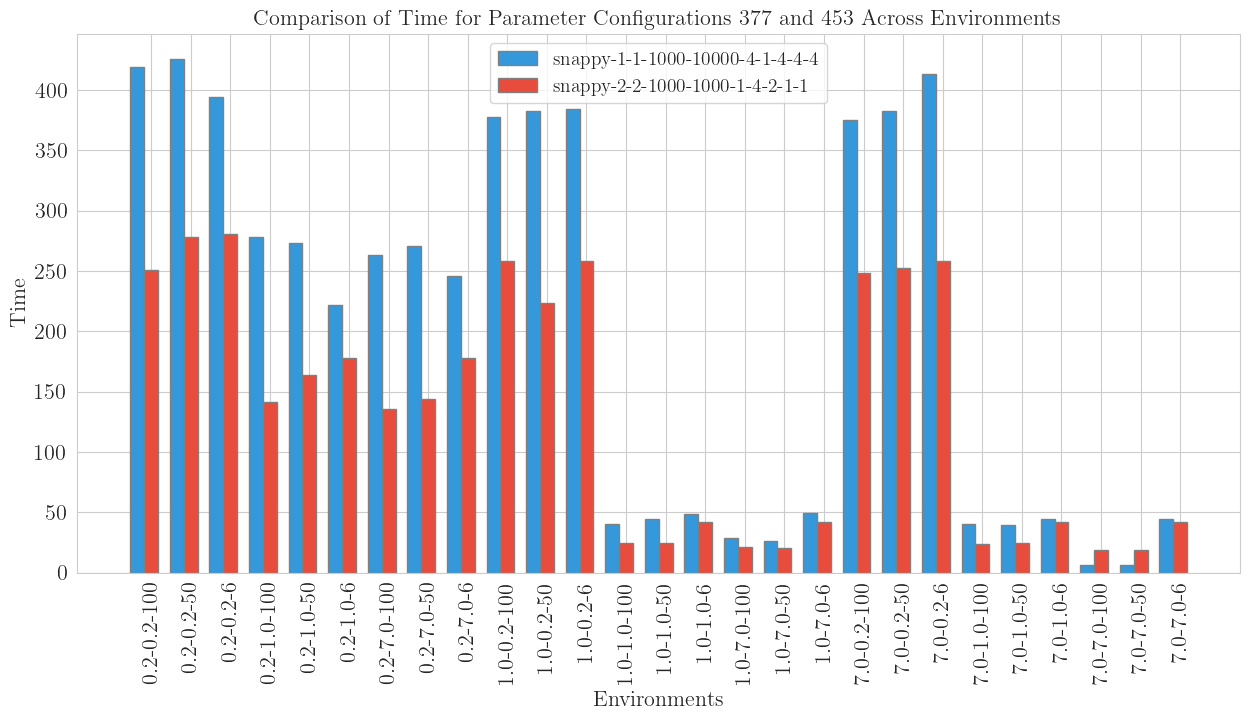

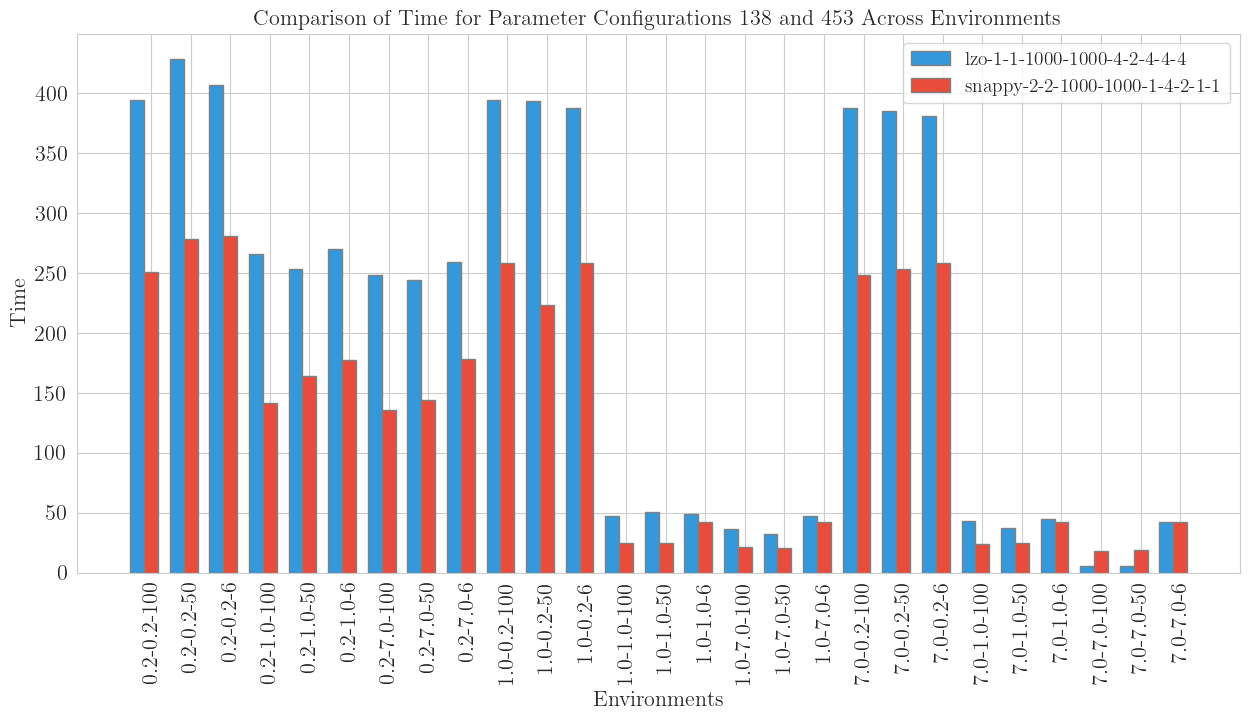

In [113]:
# Choose two distinct colors
color1 = '#3498db'  # A shade of blue
color2 = '#e74c3c'  # A shade of red

# Number of top pairs to visualize
N = 10

# Get the indices of the top N pairs
top_indices = np.dstack(np.unravel_index(np.argsort(combined_score_masked.ravel())[-N:], combined_score.shape))[0]

# Iterate over the top pairs and plot them
for idx in top_indices:
    i, j = idx
    config1 = pivot_df.index[i]
    config2 = pivot_df.index[j]

    # Plotting
    data1 = pivot_df.loc[config1].values
    data2 = pivot_df.loc[config2].values
    barWidth = 0.35
    r1 = range(len(data1))
    r2 = [x + barWidth for x in r1]

    plt.figure(figsize=(15, 7))
    plt.bar(r1, data1, width=barWidth, color=color1, edgecolor='grey', label=str(config1))
    plt.bar(r2, data2, width=barWidth, color=color2, edgecolor='grey', label=str(config2))
    plt.title(f'Comparison of Time for Parameter Configurations {i+1} and {j+1} Across Environments')
    plt.xlabel('Environments', fontweight='bold')
    plt.ylabel('Time', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(data1))], pivot_df.columns, rotation=90)
    plt.legend()
    plt.show()


In [96]:
parameter_cols = ['compression', 'format', 'network_parallelism', 'bufpool_size', 'buff_size', 
                  'client_read_par', 'client_decomp_par', 'server_read_par', 'server_read_partitions', 'server_deser_par']
env_cols = ['server_cpu','client_cpu','network']
res_cols = ['time']
# The existing code you provided is used here to prepare the pivot_df
df_copy = df.copy()
df_copy = df_copy[(df_copy['compression'] != 'zlib') & (df_copy['compression'] != 'cols')]
df_copy['param_config'] = df_copy[parameter_cols].astype(str).agg('-'.join, axis=1)
df_copy['environment'] = df_copy[env_cols].astype(str).agg('-'.join, axis=1)

param_combinations = df_copy[parameter_cols].drop_duplicates()
param_combinations['param_id'] = range(1, len(param_combinations) + 1)

# Create a unique identifier for each environment
environments = df_copy[env_cols].drop_duplicates()
environments['env_id'] = range(1, len(environments) + 1)

# Now, merge these back into your original dataframe to get 'param_id' and 'env_id' for each row
df_with_ids = df_copy.merge(param_combinations, on=parameter_cols, how='left')
df_with_ids = df_with_ids.merge(environments, on=env_cols, how='left')

# Now, filter out parameter configurations that do not have values for all 27 environments
env_counts = df_with_ids.groupby('param_id')['env_id'].nunique()
valid_param_ids = env_counts[env_counts == 27].index
df_valid_params = df_with_ids[df_with_ids['param_id'].isin(valid_param_ids)].copy()

# Check for duplicates based on 'param_id' and 'env_id'
duplicates = df_valid_params.duplicated(subset=['param_id', 'env_id'], keep=False)
if duplicates.any():
    df_valid_params = (
        df_valid_params.groupby(['param_id', 'env_id'], as_index=False)
        .agg({'time': 'mean', **{col: 'first' for col in df_valid_params.columns if col not in ['param_id', 'env_id', 'time']}})
    )

# Now, assign ranks consecutively within each 'param_id' group
df_valid_params['consecutive_rank'] = df_valid_params.groupby('param_id')['time'].rank(method='first', ascending=True)

# Only retain the columns of interest for the 'rankings_df'.
rankings_df = df_valid_params[['param_id', 'env_id', 'consecutive_rank']]

# Sort the DataFrame based on 'param_id' and 'consecutive_rank'.
rankings_df = rankings_df.sort_values(by=['param_id', 'consecutive_rank'])

# Reset the index of the DataFrame.
rankings_df.reset_index(drop=True, inplace=True)

# Display the result
display(rankings_df)

param_id  env_id  consecutive_rank
0             6      20               1.0
1             6      19               2.0
2             6       7               3.0
3             6       1               4.0
4             6       9               5.0
5             6      21               6.0
6             6      23               7.0
7             6       3               8.0
8             6      13               9.0
9             6      15              10.0
10            6      24              11.0
11            6      22              12.0
12            6      10              13.0
13            6      16              14.0
14            6      14              15.0
15            6       8              16.0
16            6       4              17.0
17            6       2              18.0
18            6       5              19.0
19            6      11              20.0
20            6      25              21.0
21            6      17              22.0
22            6      27              23.0
23            6      26              24.0
24            6      18              25.0
25            6       6              26.0
26            6      12              27.0
27           47      20               1.0
28           47      19               2.0
29           47      21               3.0
30           47      23               4.0
31           47       7               5.0
32           47       1               6.0
33           47       9               7.0
34           47       3               8.0
35           47      22               9.0
36           47      24              10.0
37           47      13              11.0
38           47      15              12.0
39           47      10              13.0
40           47      14              14.0
41           47      16              15.0
42           47       8              16.0
43           47       4              17.0
44           47       2              18.0
45           47      25              19.0
46           47      11              20.0
47           47       5              21.0
48           47      26              22.0
49           47      27              23.0
50           47      17              24.0
51           47       6              25.0
52           47      12              26.0
53           47      18              27.0
54           65      20               1.0
55           65       1               2.0
56           65       7               3.0
57           65      19               4.0
58           65      21               5.0
59           65      23               6.0
60           65       9               7.0
61           65       3               8.0
62           65      15               9.0
63           65      13              10.0
64           65      22              11.0
65           65      24              12.0
66           65       4              13.0
67           65      10              14.0
68           65       8              15.0
69           65       2              16.0
70           65      14              17.0
71           65      16              18.0
72           65       5              19.0
73           65       6              20.0
74           65      25              21.0
75           65      11              22.0
76           65      27              23.0
77           65      17              24.0
78           65      12              25.0
79           65      26              26.0
80           65      18              27.0
81           94      20               1.0
82           94       1               2.0
83           94       7               3.0
84           94      19               4.0
85           94      21               5.0
86           94       9               6.0
87           94      23               7.0
88           94       3               8.0
89           94      15               9.0
90           94      22              10.0
91           94      24              11.0
92           94      13              12.0
93           94       4              13.0
94           94  

In [99]:
from operator import itemgetter
# Initialize an empty list to store the differences and the pairs
rank_differences = []

# Calculate rank differences between all pairs for each environment
for env, row in pivot_ranks.iterrows():
    for (param1, rank1), (param2, rank2) in itertools.combinations(row.iteritems(), 2):
        rank_diff = abs(rank1 - rank2)
        rank_differences.append((rank_diff, param1, param2, env))

# Sort the list of tuples by the rank difference in descending order
rank_differences.sort(key=itemgetter(0), reverse=True)

# Now you can iterate over this sorted list and pick pairs that can form valid triplets
valid_triplets = []
seen_pairs = set()

for diff, param1, param2, env in rank_differences:
    # Avoid reusing pairs in the same triplet
    if (param1, param2) in seen_pairs or (param2, param1) in seen_pairs:
        continue
    
    # Check for a third parameter that forms a valid triplet with the pair
    for param3 in pivot_ranks.columns:
        if param3 == param1 or param3 == param2:
            continue
        # Criteria for a valid triplet: param3 should have a different rank compared to param1/param2
        param3_rank = pivot_ranks.at[env, param3]
        if param3_rank != pivot_ranks.at[env, param1] and param3_rank != pivot_ranks.at[env, param2]:
            valid_triplets.append((param1, param2, param3))
            seen_pairs.add((param1, param2))
            break
    
    # Limit the number of triplets if necessary
    if len(valid_triplets) >= 10:  # For example, if you want at most 5 triplets
        break

# Convert the list of triplets into a DataFrame
triplets_df = pd.DataFrame(valid_triplets, columns=['param_id1', 'param_id2', 'param_id3'])

# Display the DataFrame
print(triplets_df)

/tmp/ipykernel_68229/4146855671.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (param1, rank1), (param2, rank2) in itertools.combinations(row.iteritems(), 2):


   param_id1  param_id2  param_id3
0         65      31339          6
1         94      31339          6
2        149      31339          6
3        161      31339          6
4        259      31339          6
5        274      31339          6
6        293      31339          6
7        295      31339          6
8        407      31339          6
9        410      31339          6


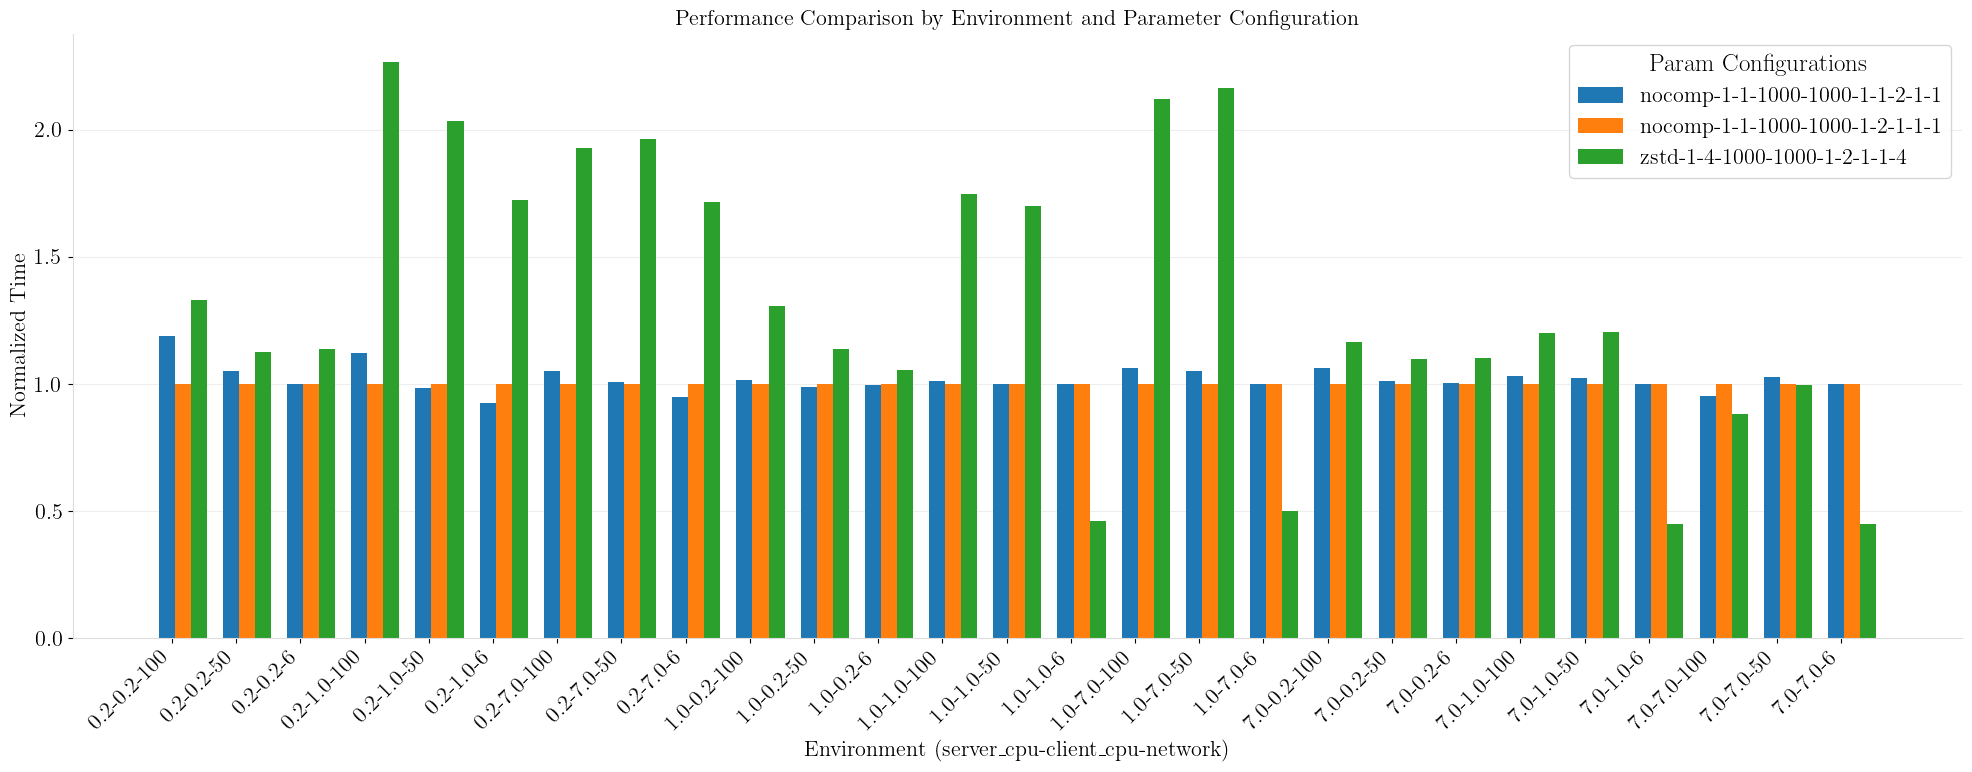

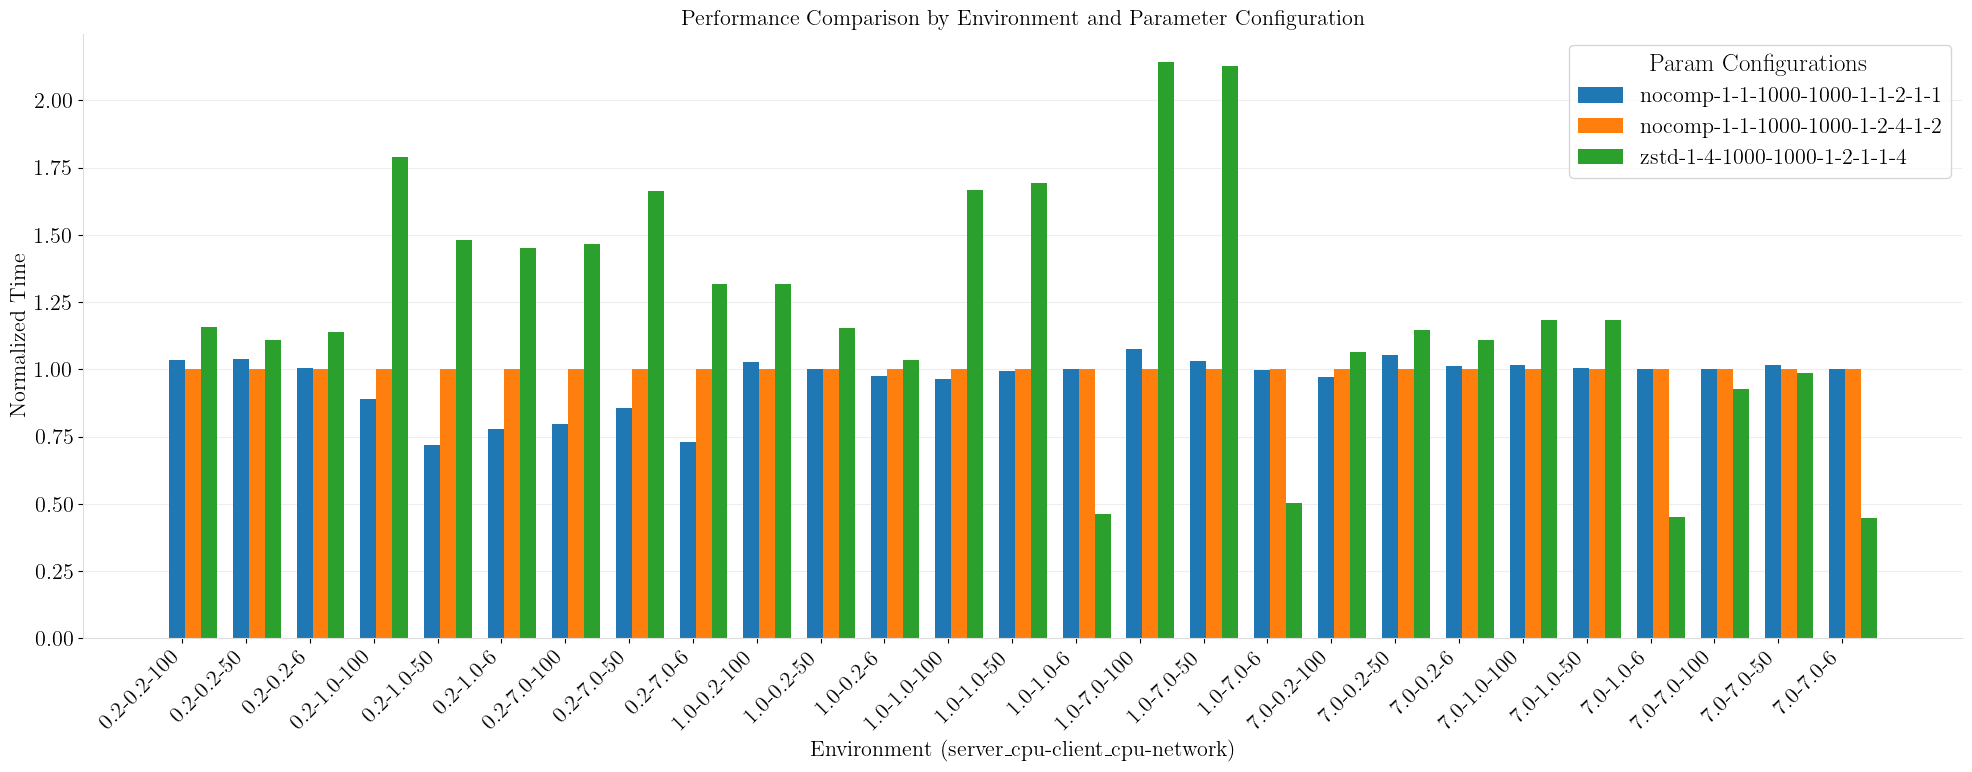

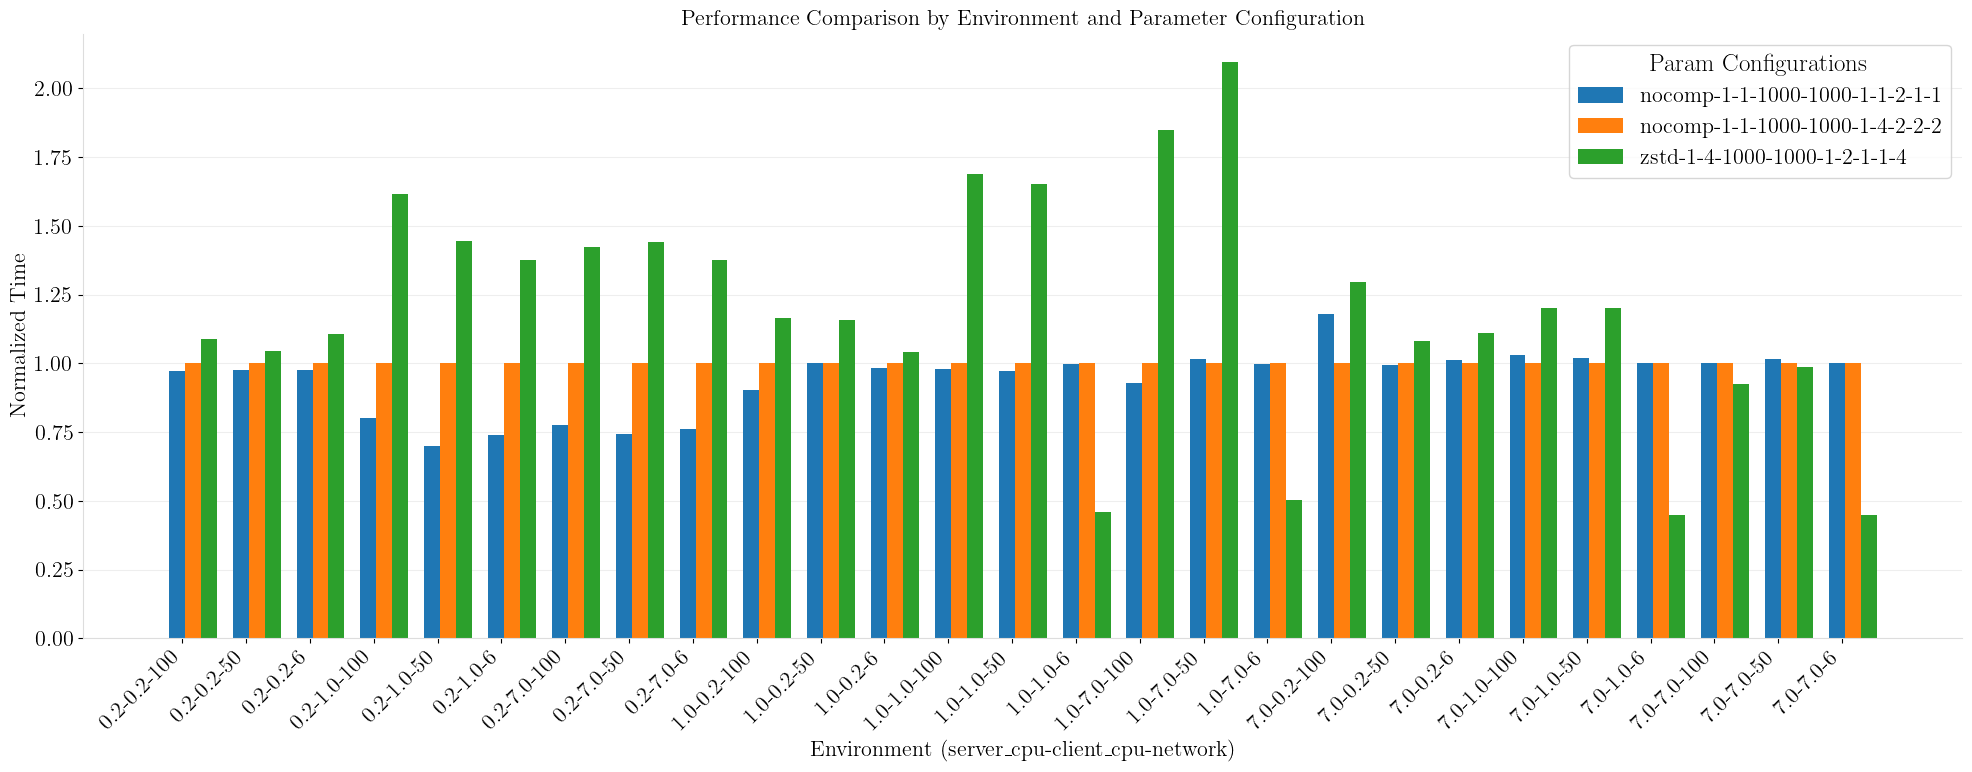

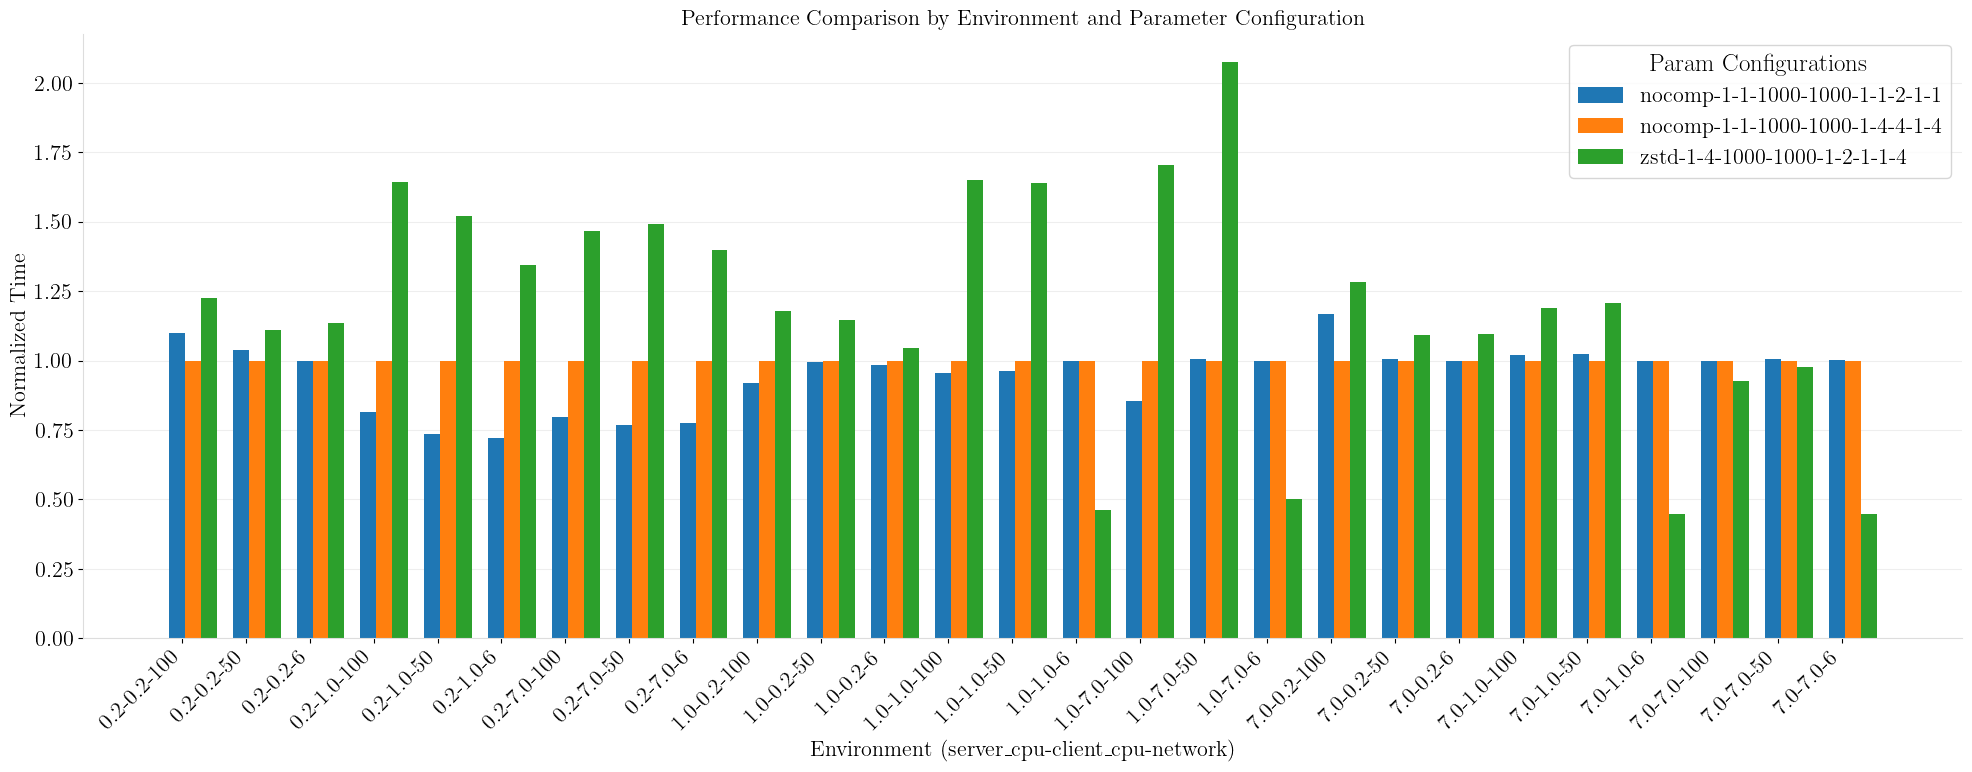

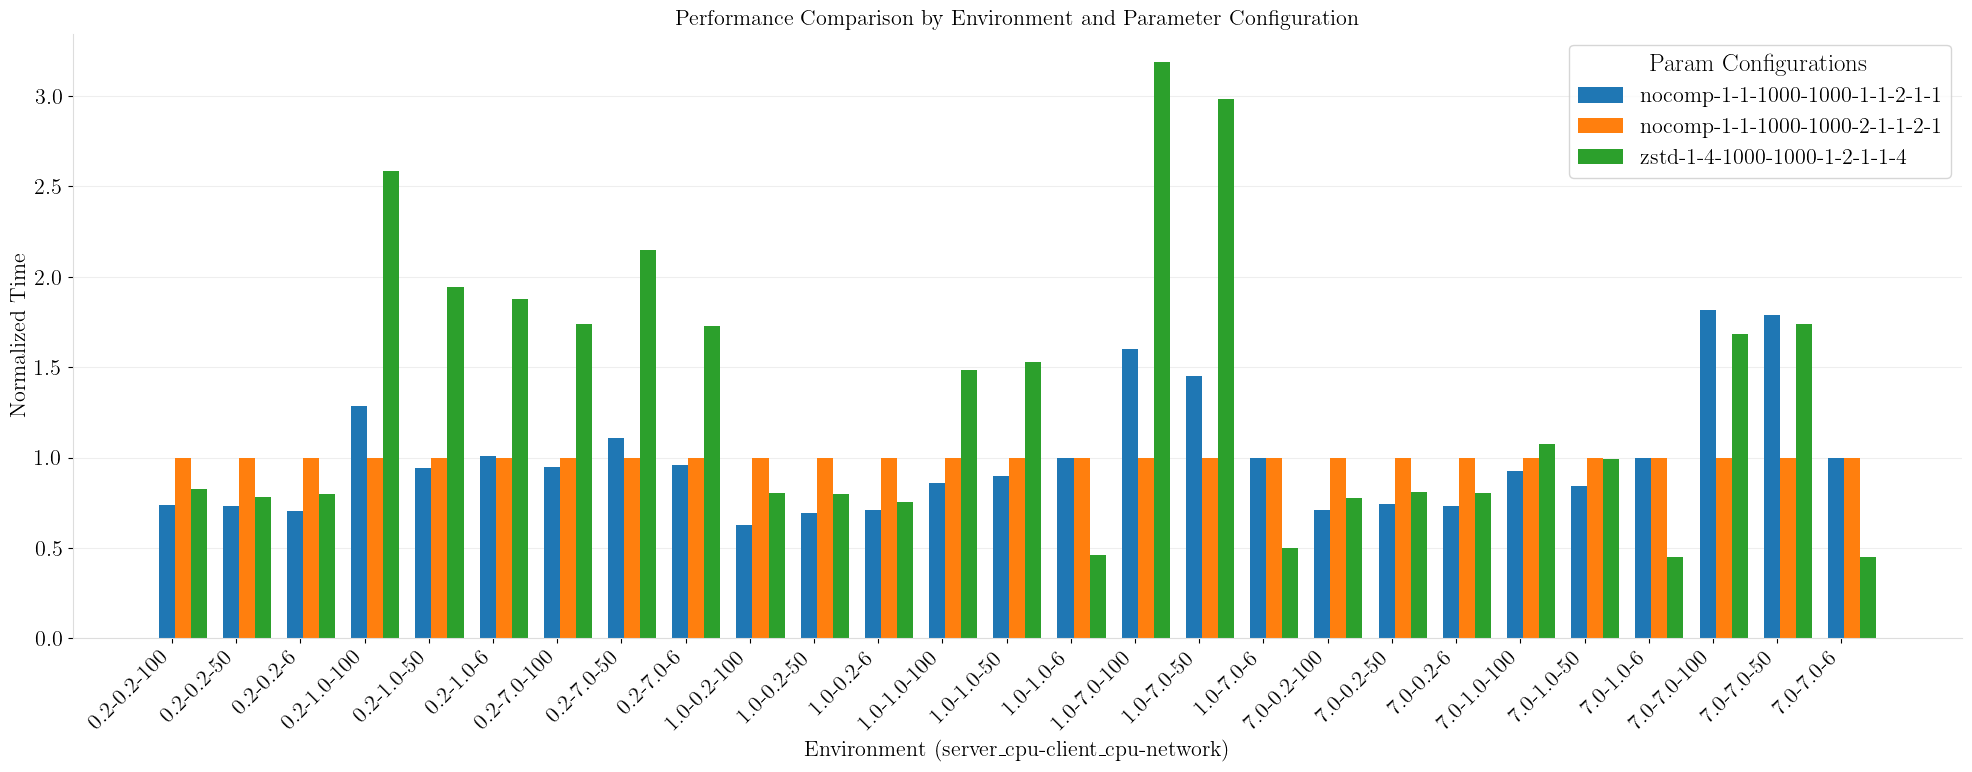

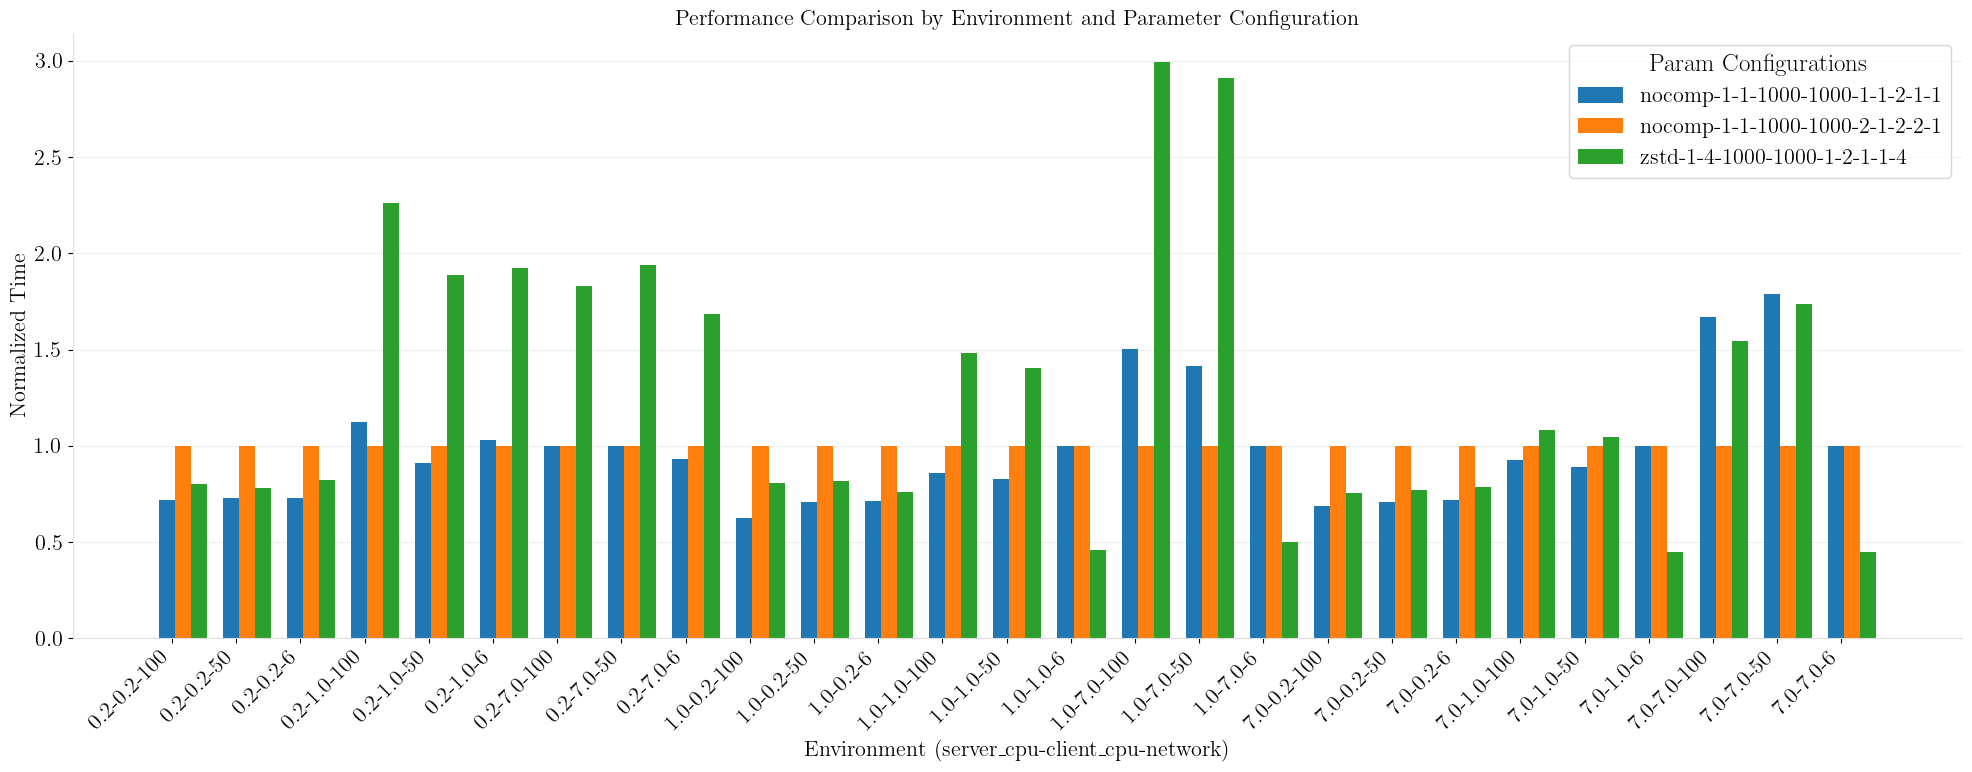

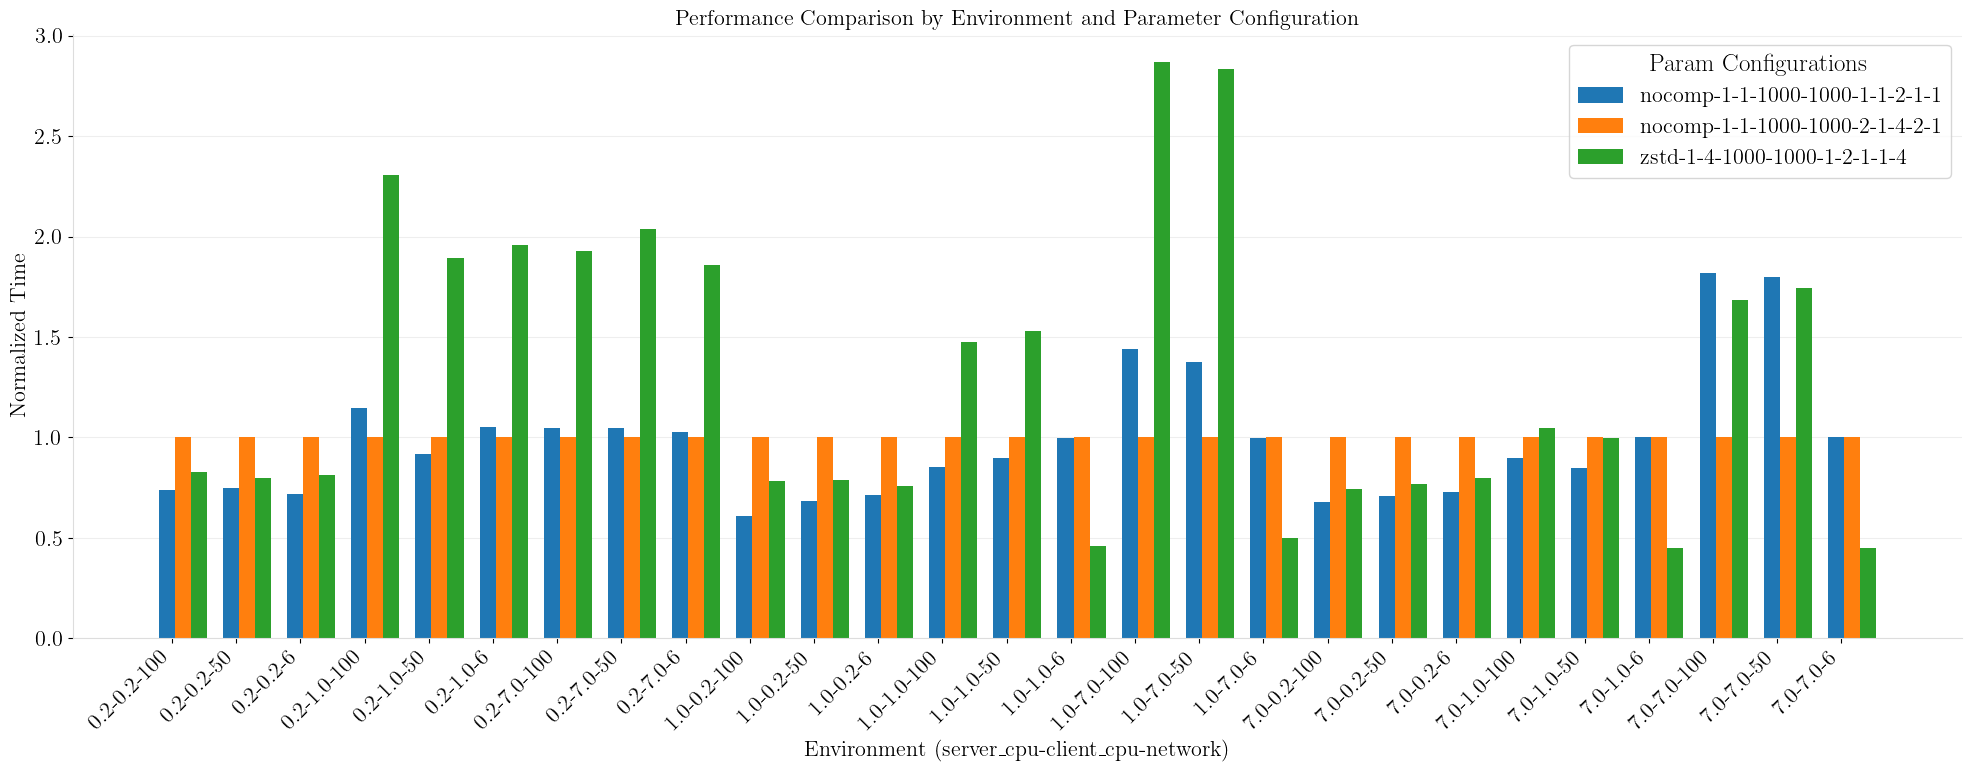

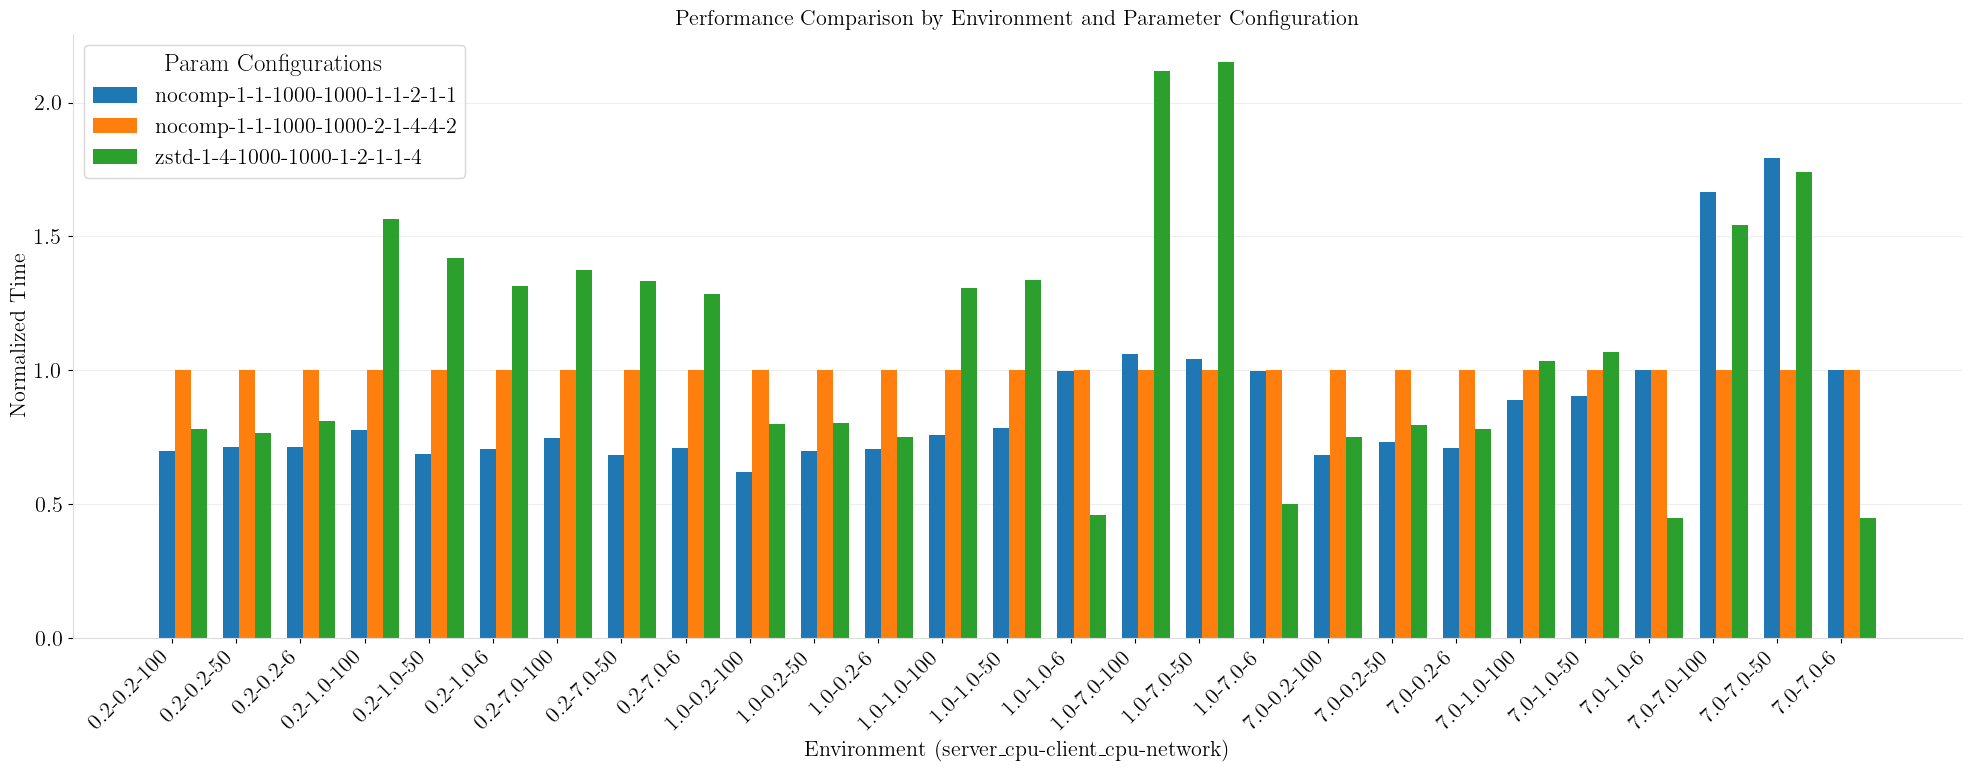

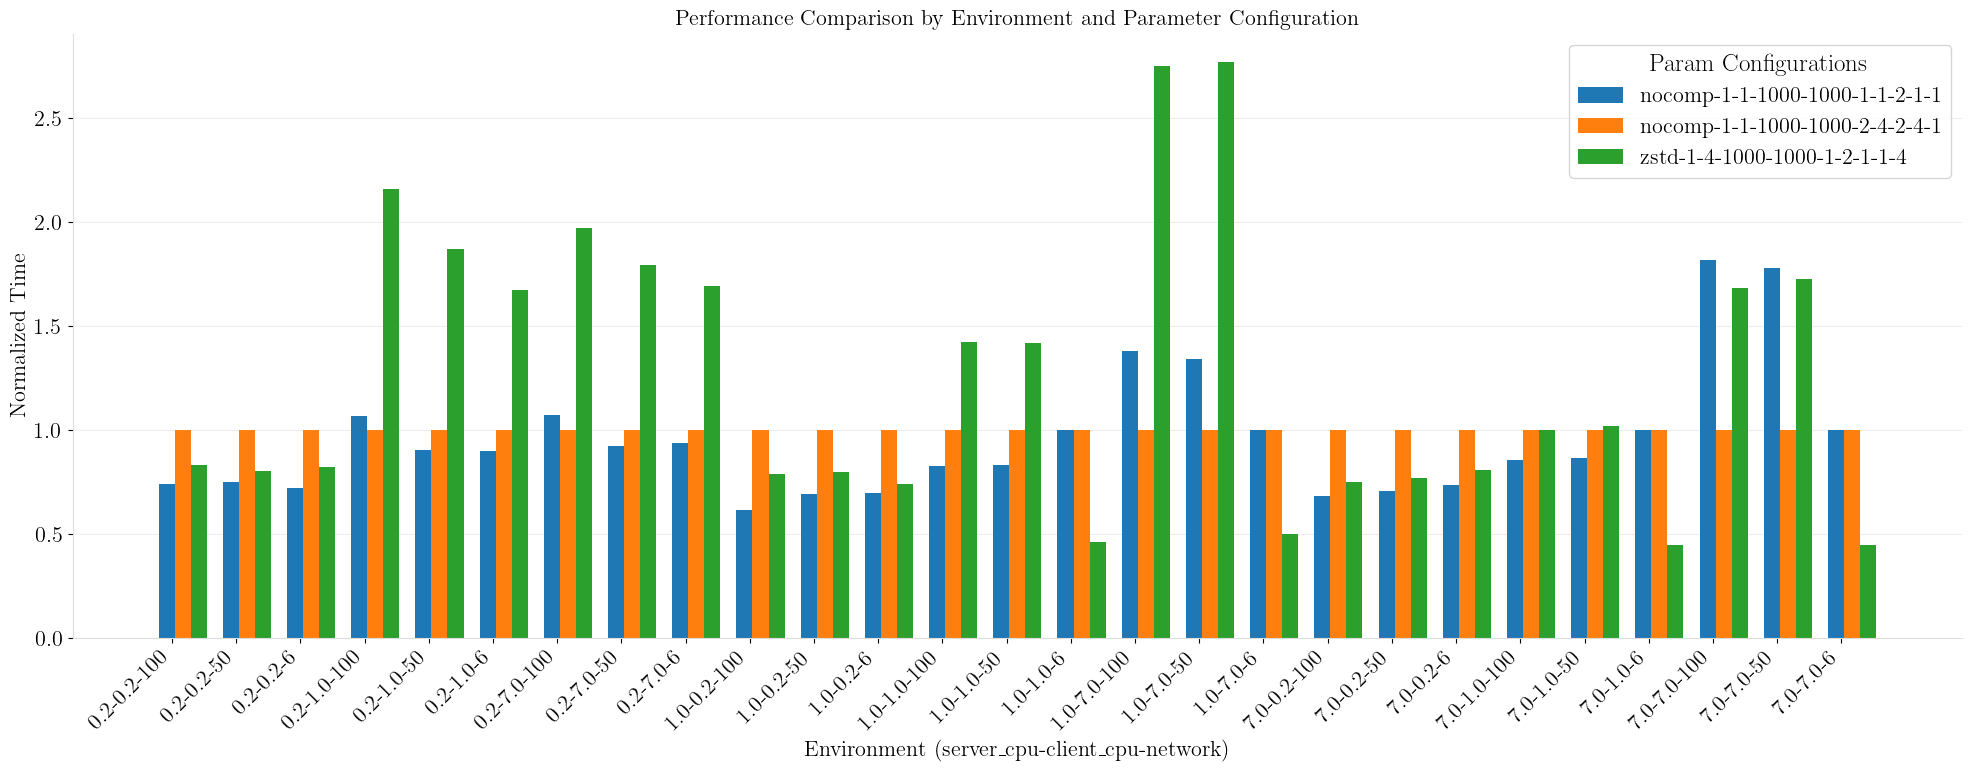

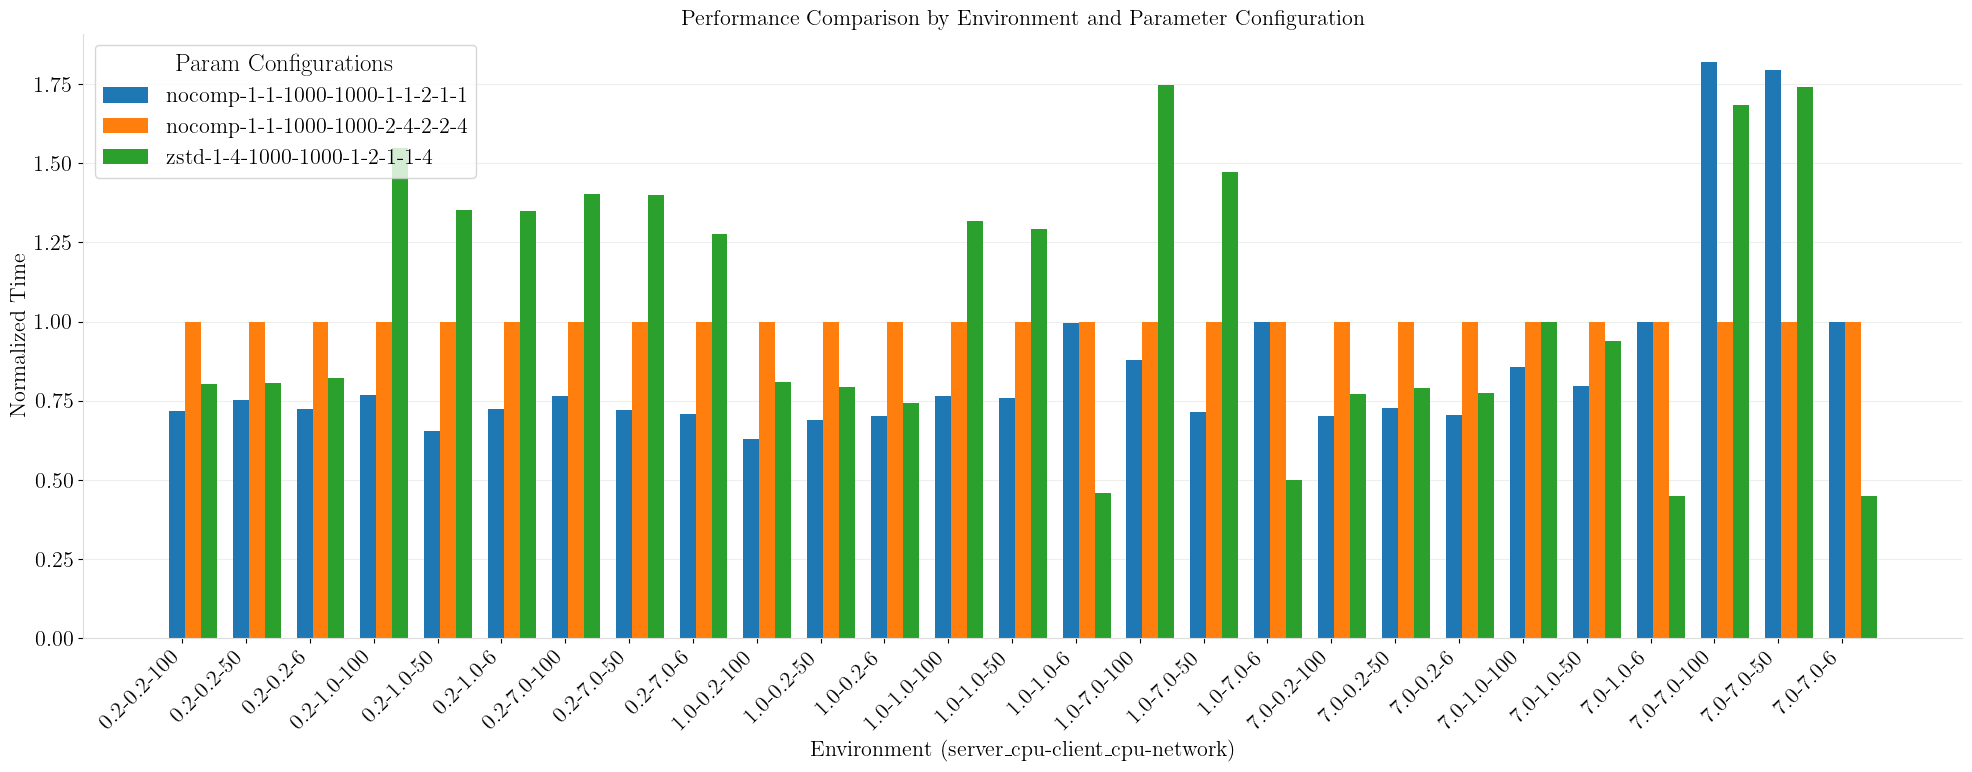

In [102]:
triplets_to_plot = triplets_df.head(10).values

for triplet in triplets_to_plot:
    # Filter the DataFrame for the current triplet
    triplet_df = df_with_ids[df_with_ids['param_id'].isin(triplet)]
    
    # Aggregate times by taking the mean for each param_id and env_id combination
    aggregated_times = (
        triplet_df.groupby(['param_id', 'env_id'])
        .agg({'time': 'mean'})
        .reset_index()
    )
    
    # Normalize the times
    baseline_times = aggregated_times[aggregated_times['param_id'] == triplet[0]][['env_id', 'time']]
    df_normalized = aggregated_times.merge(baseline_times, on='env_id', suffixes=('', '_baseline'))
    df_normalized['normalized_time'] = df_normalized['time'] / df_normalized['time_baseline']

    # Mapping the ids to the actual parameter configurations and environment strings
    df_normalized['param_config'] = df_normalized['param_id'].map(param_id_to_config)
    df_normalized['env_string'] = df_normalized['env_id'].map(env_id_to_environment)

    # Pivot the data for plotting
    pivot_df = df_normalized.pivot_table(index='env_string', columns='param_config', values='normalized_time')

   
    bar_width = 0.25  # Adjust as necessary
    n_groups = len(pivot_df.index)
    n_bars = len(pivot_df.columns)
    
    # The x locations for the groups
    ind = np.arange(n_groups)
    
    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(20, 8))
    
    # Plot each set of bars
    for i in range(n_bars):
        ax.bar(ind + i * bar_width, pivot_df.iloc[:, i], bar_width, label=f'{pivot_df.columns[i]}')
    
    # Add some text for labels, title, and customizing the axes ticks
    ax.set_xlabel('Environment (server_cpu-client_cpu-network)', fontsize=16)
    ax.set_ylabel('Normalized Time', fontsize=16)
    ax.set_title('Performance Comparison by Environment and Parameter Configuration', fontsize=16)
    ax.set_xticks(ind + bar_width / n_bars)
    ax.set_xticklabels((pivot_df.index), rotation=45, ha='right', fontsize=16)
    
    # Add a legend
    ax.legend(title='Param Configurations', fontsize=16, title_fontsize=18)
    
    # Add gridlines below the bars
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)
    
    # Tweak the style of the axes spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.spines['left'].set_color('#DDDDDD')
    
    # Show the plot
    plt.tight_layout()  # This ensures that all labels and titles are visible
    plt.show()


system                    27
compression               27
format                    27
network_parallelism       27
bufpool_size              27
buff_size                 27
network                   27
client_cpu                27
client_read_par           27
client_decomp_par         27
server_cpu                27
server_read_par           27
server_read_partitions    27
server_deser_par          27
time                      27
datasize                  27
environment               27
env_strength              27
dtype: int64


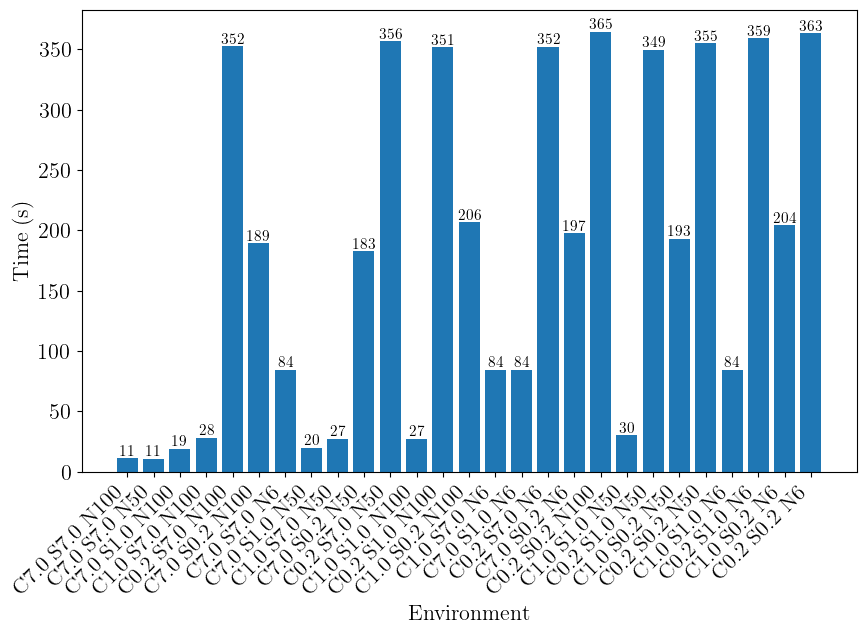

In [9]:
def normalize(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value)



filtered_df = df.copy()
filtered_df = filtered_df[
    (filtered_df["system"] == "csv") &
    (filtered_df["bufpool_size"] == 1000) &
    (filtered_df["buff_size"] == 1000) &
    (filtered_df["compression"] == "nocomp") &
    (filtered_df["format"] == 1) &
    (filtered_df["network_parallelism"] == 2) &
    (filtered_df["client_read_par"] == 2) &
    (filtered_df["client_decomp_par"] == 2) &
    (filtered_df["server_read_par"] == 2) &
    (filtered_df["server_read_partitions"] == 2) &
    (filtered_df["server_deser_par"] == 2)
]
filtered_df['environment'] = 'C' + filtered_df['client_cpu'].astype(str) + ' S' + filtered_df['server_cpu'].astype(str) + ' N' + filtered_df['network'].astype(str)
filtered_df['env_strength'] = normalize(filtered_df['client_cpu'],.2,7) + normalize(filtered_df['server_cpu'],.2,7) + 1*normalize(filtered_df['network'],6,100)
filtered_df = filtered_df.sort_values(by='env_strength', ascending=False)

columns_to_consider = [col for col in df.columns if col not in ['time', 'datasize']]
filtered_df = filtered_df.drop_duplicates(subset=columns_to_consider, keep='first')

print(filtered_df.count())

# Create a bar plot.
plt.figure(figsize=(10, 6))
bars = plt.bar(filtered_df['environment'], filtered_df['time'])

plt.xlabel('Environment')
plt.ylabel('Time (s)')
#plt.title('Runtime')
plt.xticks(rotation=45, ha='right')

# Adding a number label above each bar.
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval), ha='center', va='bottom',  fontsize=11)  # You might need to adjust the position values to fit your specific needs.

#plt.savefig(f'paper_plots/environment_impact.pdf', bbox_inches='tight')
plt.show()


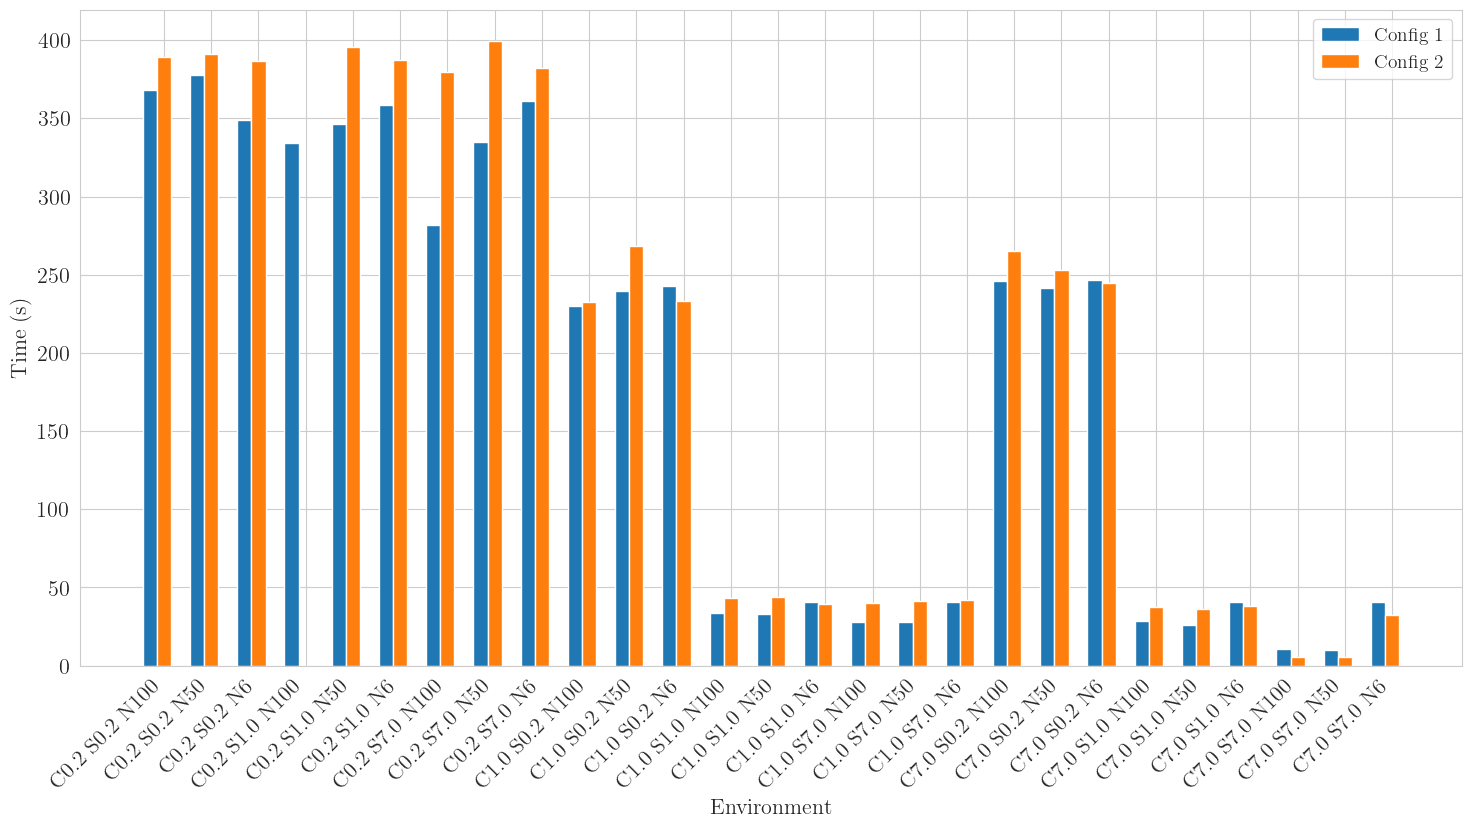

In [71]:
def normalize(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value)



filtered_df = df.copy()
filtered_df = filtered_df[
    (filtered_df["system"] == "csv") &
    (filtered_df["bufpool_size"] == 1000) &
    (filtered_df["buff_size"] == 10000) &
    (filtered_df["compression"] == "snappy") &
    (filtered_df["format"] == 2) &
    (filtered_df["network_parallelism"] == 2) &
    (filtered_df["client_read_par"] == 2) &
    (filtered_df["client_decomp_par"] == 2) &
    (filtered_df["server_read_par"] == 2) &
    (filtered_df["server_read_partitions"] == 2) &
    (filtered_df["server_deser_par"] == 4)
]
filtered_df['environment'] = 'C' + filtered_df['client_cpu'].astype(str) + ' S' + filtered_df['server_cpu'].astype(str) + ' N' + filtered_df['network'].astype(str)
filtered_df['env_strength'] = (normalize(filtered_df['client_cpu'],.2,7) + normalize(filtered_df['server_cpu'],.2,7) + 1*normalize(filtered_df['network'],6,100))/3
filtered_df = filtered_df.sort_values(by='env_strength', ascending=False)

filtered_df2 = df.copy()
filtered_df2 = filtered_df2[
    (filtered_df2["system"] == "csv") &
    (filtered_df2["bufpool_size"] == 1000) &
    (filtered_df2["buff_size"] == 1000) &
    (filtered_df2["compression"] == "zstd") &
    (filtered_df2["format"] == 2) &
    (filtered_df2["network_parallelism"] == 2) &
    (filtered_df2["client_read_par"] == 4) &
    (filtered_df2["client_decomp_par"] == 1) &
    (filtered_df2["server_read_par"] == 4) &
    (filtered_df2["server_read_partitions"] == 1) &
    (filtered_df2["server_deser_par"] == 4)
]
filtered_df2['environment'] = 'C' + filtered_df2['client_cpu'].astype(str) + ' S' + filtered_df2['server_cpu'].astype(str) + ' N' + filtered_df2['network'].astype(str)
filtered_df2['env_strength'] = (normalize(filtered_df2['client_cpu'],.2,7) + normalize(filtered_df2['server_cpu'],.2,7) + 1*normalize(filtered_df2['network'],6,100))/3
filtered_df2 = filtered_df2.sort_values(by='env_strength', ascending=False)

# Assuming filtered_df_2 is your second DataFrame after applying your different conditions and calculations

# Ensure that both DataFrames have the same 'environments' sorted in the order you want them to appear in the plot
environments = sorted(set(filtered_df['environment']) | set(filtered_df2['environment']))

# Getting the 'time' values corresponding to each 'environment' from both DataFrames
times_1 = [filtered_df[filtered_df['environment'] == env]['time'].values[0] if env in filtered_df['environment'].values else 0 for env in environments]
times_2 = [filtered_df2[filtered_df2['environment'] == env]['time'].values[0] if env in filtered_df2['environment'].values else 0 for env in environments]

# The position of the bars on the x-axis
ind = np.arange(len(environments))

# Width of the bars
width = 0.3  # Smaller than before, leading to wider space between the bars.

# Calculate the space between groups. This will be used to create a gap between groups.
space_between_groups = 0.1  # This can be adjusted depending on the desired space.
total_width = 2 * width + space_between_groups
num_groups = len(environments)

# Calculating the positions of the bars and the groups
indices_group_positions = np.arange(0, num_groups * total_width, total_width)

# Creating a larger figure to accommodate all bars and labels without overlapping.
fig, ax = plt.subplots(figsize=(15, 8))  # Increase figure size.

# Create bars; they are now more separated.
bar1 = ax.bar(ind - width/2, times_1, width, label='Config 1')
bar2 = ax.bar(ind + width/2, times_2, width, label='Config 2')

ax.set_xlabel('Environment')
ax.set_ylabel('Time (s)')

# Adjusting the ticks' positions so they are at the center of the groups.
ax.set_xticks(ind + width/2)  # centering the ticks with the grouped bars


ax.set_xticklabels(environments, rotation=45, ha='right')  # Adjust for better readability if needed.
ax.legend()

# Label with label_type 'center'
#ax.bar_label(bar1, label_type='center')
#ax.bar_label(bar2, label_type='center')

fig.tight_layout()

# If the x labels are still not fitting well, you can adjust further by setting the aspect of the plot.
plt.gcf().subplots_adjust(bottom=0.15)  # Adjust subplot parameters to give the x-labels more space.

#plt.savefig('grouped_bar_plot_spaced.pdf', bbox_inches='tight')
plt.show()


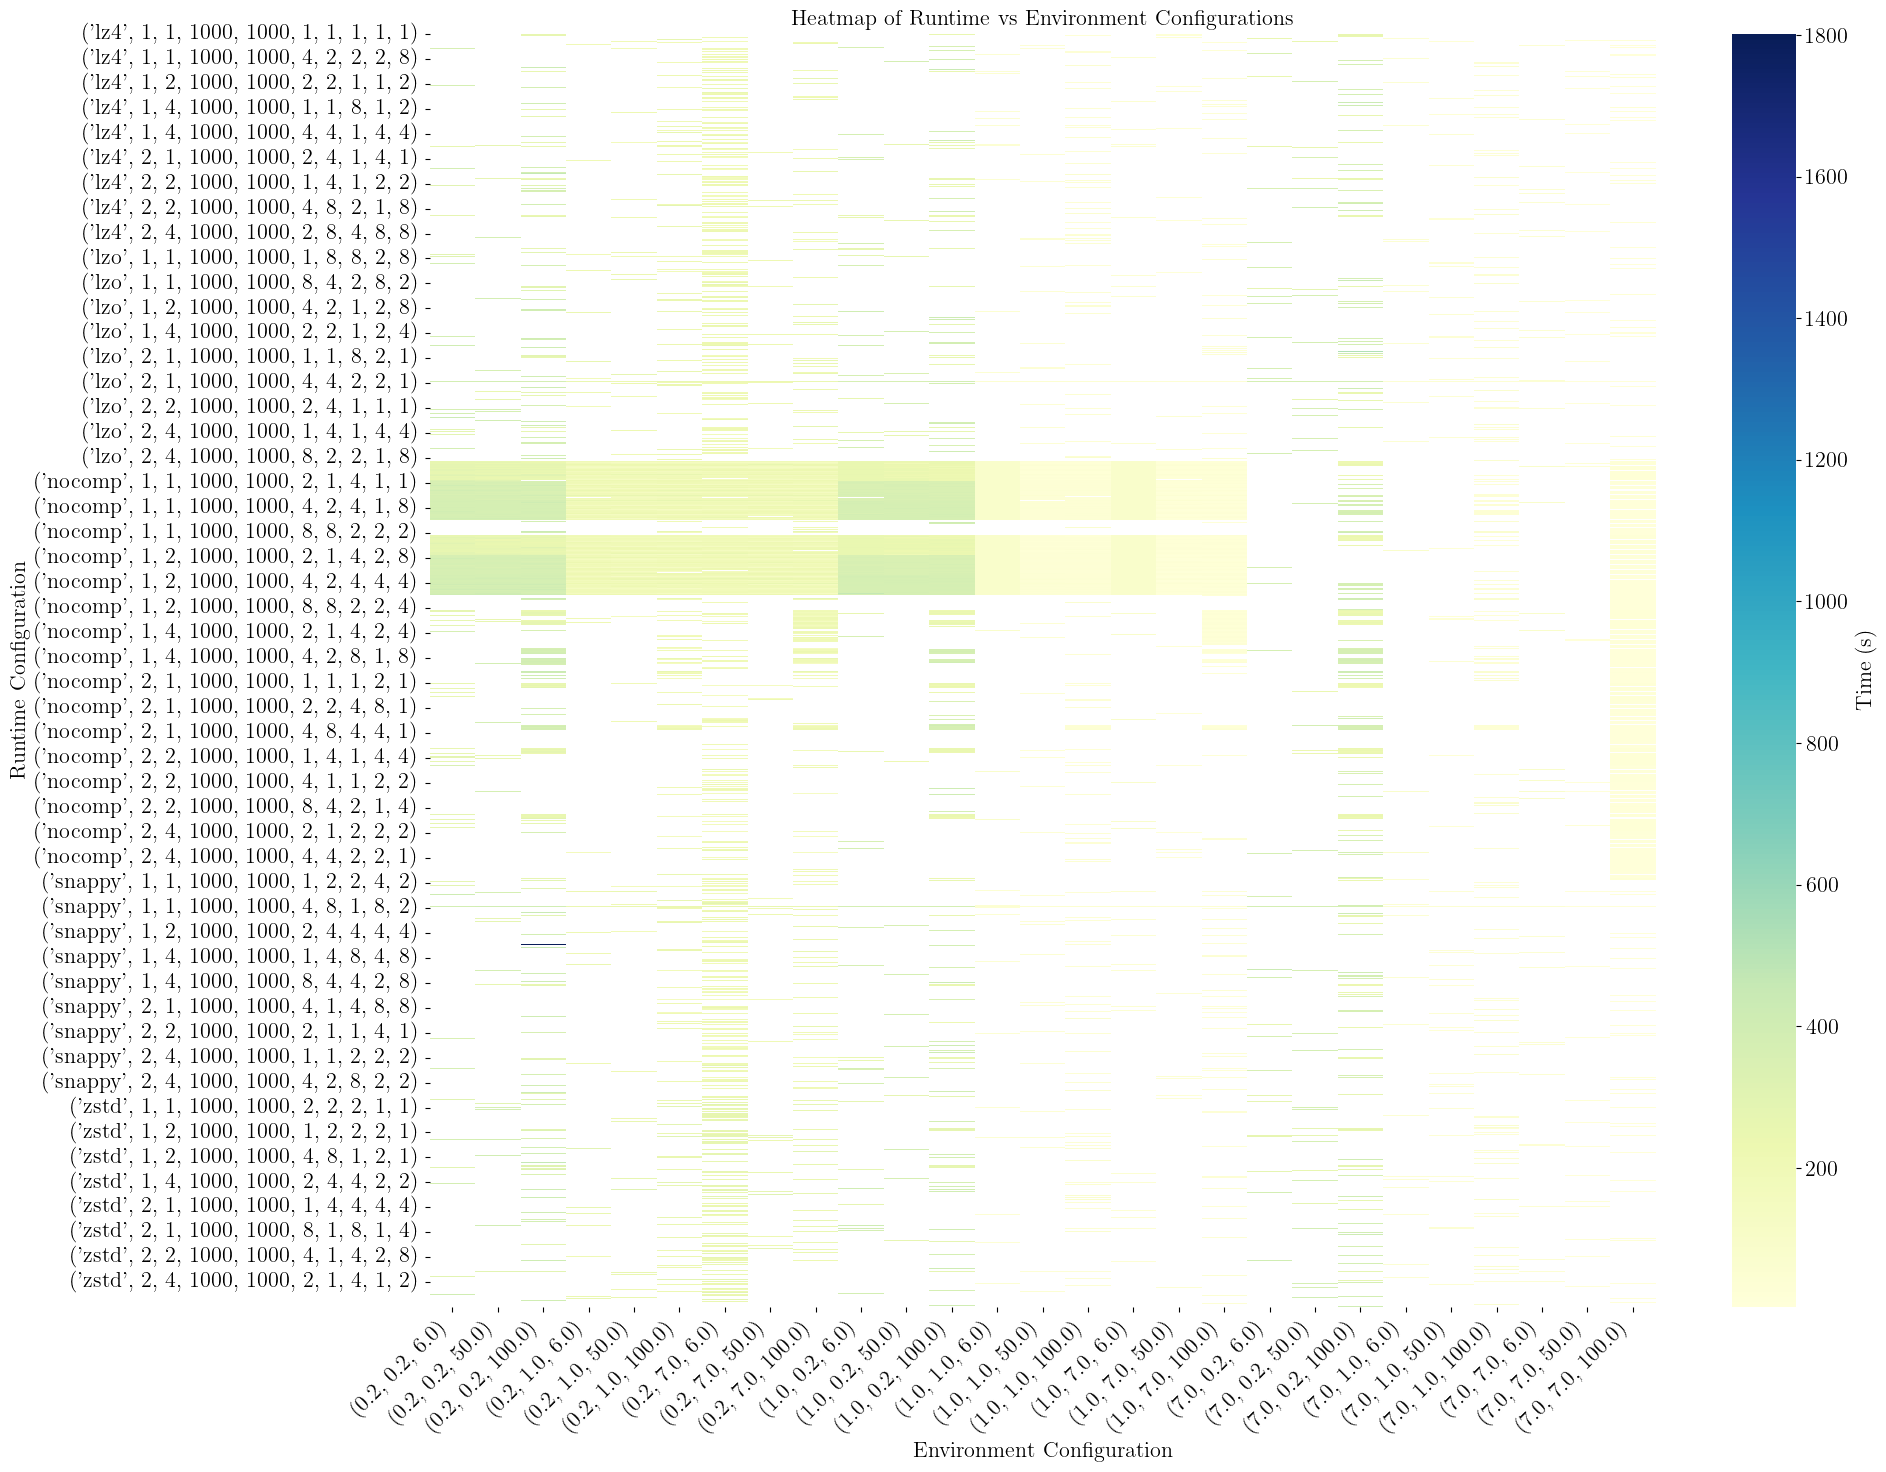

In [10]:
df_copy['runtime_config'] = df_copy[runtime_config_cols].apply(tuple, axis=1)
df_copy['environment_config'] = df_copy[environment_config_cols].apply(tuple, axis=1)

# Pivot table for heatmap
pivot_table = df_copy.pivot_table(index='runtime_config', columns='environment_config', values='time', aggfunc=np.mean)

plt.figure(figsize=(20, 15))
sns.heatmap(pivot_table, cmap='YlGnBu', cbar_kws={'label': 'Time (s)'})
plt.xticks(rotation=45, ha='right')
plt.ylabel('Runtime Configuration')
plt.xlabel('Environment Configuration')
plt.title('Heatmap of Runtime vs Environment Configurations')
plt.tight_layout()
plt.show()

In [6]:
plt.figure(figsize=(20, 15))
sns.boxplot(data=df_copy, x='runtime_config', y='time')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Time (s)')
plt.xlabel('Runtime Configuration')
plt.title('Boxplots of Time for Each Runtime Configuration')
plt.tight_layout()
plt.show()


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7f3eb73efd30> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x7f3eb35c4040> (for post_execute):


KeyboardInterrupt: 

In [27]:
data = df.copy()
#data = data[data['compression']!='nocomp']
# Filter out the desired records based on the environment conditions.
condition = (
    (data['client_cpu'] == 7) & 
    (data['server_cpu'] == 0.2) & 
    (data['network'] == 6)
)

# Create a new dataframe with conditions, naming it 'environment_df'
environment_df = data[condition]

# Define the columns to consider for sorting, excluding the ones you mentioned to be skipped.
columns_to_consider = [
    'compression', 'format', 'network_parallelism', 'bufpool_size', 
    'buff_size', 'client_read_par', 'client_decomp_par',
    'server_read_par', 'server_read_partitions', 'server_deser_par', 'time'  # and any other relevant columns
]

environment_df = environment_df[columns_to_consider]

# Sort by 'time' in ascending order to get the configuration with the least time at the top.
environment_df = environment_df.sort_values(by='time', ascending=True)

# Select the top 25 records
top_25_records = environment_df.head(25)

# Display the top 25 records
display(top_25_records)

compression  format  network_parallelism  bufpool_size  buff_size  \
108255      nocomp       2                    1          1000       1000   
9884        nocomp       1                    1          1000       1000   
10001       nocomp       1                    1          1000       1000   
106687      nocomp       2                    1          1000       1000   
9405        nocomp       1                    1          1000       1000   
33498       nocomp       1                    2          1000       1000   
108288      nocomp       2                    2          1000       1000   
33244       nocomp       1                    2          1000       1000   
9501        nocomp       1                    1          1000       1000   
9534        nocomp       1                    1          1000       1000   
9744        nocomp       1                    1          1000       1000   
104970      nocomp       1                    2          1000       1000   
9875        nocomp       1                    1          1000       1000   
10521       nocomp       1                    1          1000       1000   
33025       nocomp       1                    2          1000       1000   
108451      nocomp       1                    1          1000      10000   
10138       nocomp       1                    1          1000       1000   
112036      nocomp       2                    1          1000      10000   
32727       nocomp       1                    2          1000       1000   
33409       nocomp       1                    2          1000       1000   
106733      nocomp       1                    1          1000      10000   
33232       nocomp       1                    2          1000       1000   
10306       nocomp       1                    1          1000       1000   
33030       nocomp       1                    2          1000       1000   
9367        nocomp       1                    1          1000       1000   

        client_read_par  client_decomp_par  server_read_par  \
108255                2                  1                1   
9884                  2                  2                4   
10001                 2                  4                2   
106687                4                  4                2   
9405                  1                  2                8   
33498                 4                  4                4   
108288                2                  2                2   
33244                 4                  1                4   
9501                  1                  4                4   
9534                  1                  4                8   
9744                  2                  1                2   
104970                8                  2                1   
9875                  2                  2                2   
10521                 4                  4                4   
33025                 2                  4                8   
108451                4                  1                4   
10138                 2                  8                4   
112036                1                  2                1   
32727                 2                  1                2   
33409                 4                  2                8   
106733                4                  4                4   
33232                 4                  1                2   
10306                 4                  1                8   
33030                 2                  4                8   
9367                  1                  2                2   

        server_read_partitions  server_deser_par    time  
108255                       1                 1  130.03  
9884                         1                 1  132.84  
10001                        2                 1  132.93  
106687                       2                 1  133.61  
9405                         1                 1  133.67  
33498                        2       